In [4]:
#    GNU LESSER GENERAL PUBLIC LICENSE
#    Version 3, 29 June 2007
#    Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
#    Everyone is permitted to copy and distribute verbatim copies
#    of this license document, but changing it is not allowed.

#    James Gaboardi, 2016

# Spatial Optimization Model Building in Python: Cplex v. Gurobi
# *p*-Dispersion Problem Holding *p* Constant 
# Increasing Matrix Dimensions

----

### James D. Gaboardi &nbsp;&nbsp; |  &nbsp;&nbsp; Florida State University &nbsp; &nbsp;|  &nbsp;&nbsp; Department of Geography 

----

$\text{The } p \text{-Dispersion problem for siting } p \text{ noxious facilities while maximizing minimum distance bewteen them.}$

---

$\text{Maximize}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $D$

$\text{Subject To}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum^n_{i = 1} y_i = p$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle d_{ij} * 2 (M - y_i - y_j) \geq D$ 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i; j  > i$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $y_i \in \{0,1\}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i$

$\text{where}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle D = \displaystyle \text{the worst case cost between a client and a service node}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle i = \text{origin index}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle n = \displaystyle \text{site index}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle d_{ij} = \text{travel costs between nodes } i \text{ and } j$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle M = \text{the largest value in } d_{ij}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle y_i  = \text{1 if selected; otherwise 0}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle p = \text{the number of facilities to be sited}$

#### &nbsp;

Adapted From:
- ***Maliszewski, Paul J., Michael J. Kuby, and Mark W. Horner***. 2012. A comparison of multi-objective spatial dispersion models for managing critical assets in urban areas. Computers, Environment and Urban Systems. 36 (4):331-341.

Originally Published:   
- ***Kuby, M. J. 1988***. Programming models for facility dispersion: the *p*-dispersion and maxisum dispersion problems. Mathematical and Computer Modelling. 10 (4):316-329.

---------------

In [5]:
# Imports
import pysal as ps
import geopandas as gpd
import numpy as np
from collections import OrderedDict
import pandas as pd
import qgrid
import cplex as cp
import gurobipy as gbp
import time
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file, show
from bokeh.charts import Bar, output_file, show
from bokeh.models import (HoverTool, BoxAnnotation, GeoJSONDataSource, 
                          GMapPlot, GMapOptions, ColumnDataSource, Circle, 
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
                          ResetTool, MultiLine)
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
output_notebook()
np.random.seed(352)

Loading BokehJS ...

In [6]:
N = 200 # Total Facilities
# List of nxn matrix dimensions
n_list = []
for i in range(1, N+1):
    matrix = 'n='+str(i)+'x'+str(i)
    n_list.append(matrix)
# List of y facility locations
y_list = []
for i in range(1, N+1):
    y = 'y'+str(i)
    y_list.append(y)

In [7]:
# Instantiate Dataframes
CPLEX_selected_df = pd.DataFrame(index=n_list, columns=y_list)
GUROBI_selected_df = pd.DataFrame(index=n_list, columns=y_list)
solvetime_df = pd.DataFrame(index=n_list)
cplex_gurobi_comparision_df = pd.DataFrame()

In [8]:
# Instantiate lists to be filled during optimization ignoring the 1x1 and 2x2 matrices
ObjVal_PDP_cplex = ['--','--']
ObjVal_PDP_gurobi = ['--','--']
solve_time_cplex = ['--','--']
solve_time_gurobi = ['--','--']
cplex_gurobi_comparision_sites = ['--','--']
cplex_gurobi_comparision_solutions = ['--','--']

In [9]:
def Cplex_and_Gurobi_pDispersion(dij, p_facilities, total_facilities, total_y):
    
    global CPLEX_selected_df
    global GUROBI_selected_df
    
    # Ignore the 1x1 and 2x2 matrices
    if total_facilities < 3:
        no_run_PDP_cplex = OrderedDict()
        no_run_PDP_gurobi = OrderedDict()
        for i in range(1, N+1):
            no_run_PDP_cplex['y'+str(i)] = ('--')
            no_run_PDP_gurobi['y'+str(i)] = ('--')
        CPLEX_selected_df = CPLEX_selected_df.append(no_run_PDP_cplex, ignore_index=True)
        GUROBI_selected_df = GUROBI_selected_df.append(no_run_PDP_gurobi, ignore_index=True)
    
    # Solve for the remainder up to NxN
    else:
        
        ######################################################################################
        #  CPLEX
        
        t1CPLEX = time.time()

        m = cp.Cplex()                                      # Instantiate a model
        m.parameters.emphasis.mip.set(2)                    # Set MIP emphasis to Optimal
        m.set_problem_type(m.problem_type.LP)               # Set problem type
        m.objective.set_sense(m.objective.sense.maximize)   # Objective Function ==>  Maximize

        # Service Nodes
        service_nodes = range(total_facilities)

        # Max Value in dij
        M_cplex = np.amax(dij)

        #  Add Variables        
        facility_variable_CPLEX = []
        for destination in service_nodes:
            facility_variable_CPLEX.append([])
            facility_variable_CPLEX[destination].append('y' + str(destination+1))

        # Add Maximized Minimum Variable
        D_cplex = 'D'
        m.variables.add(names=D_cplex,
                          obj=[1],
                           lb=[0],
                           ub=[cp.infinity],
                        types=['C'])

        # Add Facility Decision Variables
        m.variables.add(names=[facility_variable_CPLEX[destination][0] for destination in service_nodes],
                           lb=[0]*total_facilities, 
                           ub=[1]*total_facilities, 
                        types=['B']*total_facilities)

        # Add Facility Constraint
        facility_constraint_CPLEX = ([facility_variable_CPLEX[destination][0] for destination in service_nodes], 
                                     [1.0] * total_facilities)
        m.linear_constraints.add(lin_expr=[facility_constraint_CPLEX],
                                   senses=['E'],
                                      rhs=[p_facilities])

        # Add Inter-Facility Distance Constraints ==> n(n-1)/2
        index_value_rhs = [[],[],[]]
        for origin in service_nodes:
            for destination in service_nodes:
                if destination > origin:
                            index_value_rhs[0].append([facility_variable_CPLEX[origin][0]]+                \
                                                      [facility_variable_CPLEX[destination][0]]+[D_cplex])
                            index_value_rhs[1].append([-M_cplex]+[-M_cplex]+[-1.0])
                            index_value_rhs[2].append(-2*M_cplex-dij[origin][destination])
                else:
                    pass

        number_of_constraints = range(len(index_value_rhs[0]))
        for record in number_of_constraints:
            inter_facility_constraints = index_value_rhs[0][record],                       \
                                         index_value_rhs[1][record]
            m.linear_constraints.add(lin_expr=[inter_facility_constraints],                 
                                       senses=['G'], 
                                          rhs=[index_value_rhs[2][record]])

        # Optimize and Print Results
        m.write('path.lp')
        m.solve() 
        t2CPLEX = round(round(time.time()-t1CPLEX, 3)/60, 5)
        solution = m.solution
        cplex_obj_val = round(solution.get_objective_value(), 5)
        ObjVal_PDP_cplex.append(cplex_obj_val)
        solve_time_cplex.append(t2CPLEX)
        
        selected_PDP_cplex = OrderedDict()
        for f in facility_variable_CPLEX:
            if 'D' in f[0]:
                pass
            elif solution.get_values(f[0]) > 0 :
                var = '%s' % f[0]
                selected_PDP_cplex[var]=(u"\u2588")
                print ' Facility %s is selected' % f[0]
        CPLEX_selected_df = CPLEX_selected_df.append(selected_PDP_cplex, ignore_index=True)
       
        print '**********************************************************************'
        print 'Largest Value in dij (M)     = ', M_cplex
        print 'Objective Value (D)          = ', cplex_obj_val
        print 'Candidate Facilities         = ', p_facilities
        print 'Matrix Dimensions            = ', dij.shape
        print 'Real Time to Solve (seconds) = ', t2CPLEX
        print '**********************************************************************'
        print '    -- The p-Dispersion Problem CPLEX -- '
        print '    -- James Gaboardi, 2016 -- '
        print ' [n] = ', str(n), '\n\n'

        ###############################################################################    

        #  Gurobi

        t1Gurobi = time.time()

        facility_range = range(total_facilities)    # range of total facilities
        M_gurobi = np.amax(dij)                     # Max Value in dij

        mPDP = gbp.Model(" -- p-Dispersion -- ")    # Instantiate a model
        gbp.setParam('MIPFocus', 2)                 # Set MIP Focus to 2 for optimality

        # Add Decision Variables
        facility_variable_GUROBI = []
        for destination in facility_range:
            facility_variable_GUROBI.append(mPDP.addVar(vtype=gbp.GRB.BINARY,
                                                    lb=0,
                                                    ub=1,
                                                  name='y'+str(destination+1)))

        # Add Maximized Minimum Variable
        D_gurobi = mPDP.addVar(vtype=gbp.GRB.CONTINUOUS,
                           lb=0,
                           ub=gbp.GRB.INFINITY,
                         name='D')
        # Update Model Variables
        mPDP.update()       

        #  Set Objective Function
        mPDP.setObjective(D_gurobi, gbp.GRB.MAXIMIZE)

        # Add Facility Constraint
        mPDP.addConstr(gbp.quicksum(facility_variable_GUROBI[destination]                  \
                                                        for destination in facility_range) \
                                                        == p_facilities)                        

        # Add Inter-Facility Distance Constraints ==> n(n-1)/2
        for origin in facility_range:
            for destination in facility_range:
                if destination > origin:
                    mPDP.addConstr(
                                    dij[origin][destination]                             \
                                    + M_gurobi * 2                                       \
                                    - M_gurobi * facility_variable_GUROBI[origin]        \
                                    - M_gurobi * facility_variable_GUROBI[destination]   \
                                    >= D_gurobi)
                else:
                    pass

        #  Optimize and Print Results
        mPDP.optimize()
        mPDP.write('path.lp')
        gurobi_obj_val = round(mPDP.objVal,5)
        ObjVal_PDP_gurobi.append(gurobi_obj_val)
        t2Gurobi = time.time()-t1Gurobi
        solve_time_gurobi.append(t2Gurobi)
        print '\n**********************************************************************'
        selected_PDP_gurobi = OrderedDict()
        for v in mPDP.getVars():
            if 'x' in v.VarName or 'D' in v.VarName:
                pass
            elif v.x > 0:
                var = '%s' % v.VarName
                selected_PDP_gurobi[var]=(u"\u2588")
                print '    |                                            Facility %s is selected' % v.VarName

        GUROBI_selected_df = GUROBI_selected_df.append(selected_PDP_gurobi, ignore_index=True)
        print '    | Selected Facility Locations -------------  ^^^^ '
        print '    | Candidate Facilities [p] ---------------- ', len(selected_PDP_gurobi)
        print '    | Largest Value in dij (M) ---------------- ', M_gurobi
        print '    | Objective Value (D) --------------------- ', gurobi_obj_val
        print '    | Matrix Dimensions ----------------------- ', dij.shape
        print '    | Real Time to Solve (seconds)------------- ', t2Gurobi
        print '**********************************************************************'
        print '    -- The p-Dispersion Problem Gurobi -- '
        print '\n    -- James Gaboardi, 2016 -- '
        print ' [n] = ', str(n), '\n\n'
        
        ########################################################################################################
        
        print '#################################################################################################'
        print '\nCPLEX and Gurobi selected identical sites: ', selected_PDP_cplex == selected_PDP_gurobi, '\n'
        cplex_gurobi_comparision_sites.append(selected_PDP_cplex == selected_PDP_gurobi)
        print 'CPLEX and Gurobi came to identical solutions: ', cplex_obj_val == gurobi_obj_val
        cplex_gurobi_comparision_solutions.append(cplex_obj_val == gurobi_obj_val)
        print '#################################################################################################'
    

############################################################################################################  
    
# Data can be read-in or simulated
for n in range(1, N+1):
    Service = matrix_vector = n       # matrix_vector * matrix_vector for total facilities
    P = candidate_facilities = 2

    # Cost Matrix of random floats 
    Cost_Matrix = np.random.uniform(10, 
                                    30, 
                                    matrix_vector*matrix_vector)
    Cost_Matrix = Cost_Matrix.reshape(matrix_vector,matrix_vector)    

    # Call Function
    Cplex_and_Gurobi_pDispersion(dij=Cost_Matrix, 
                                 p_facilities=P, 
                                 total_facilities=Service,
                                 total_y=N)

Default row names c1, c2 ... being created.


Found incumbent of value 24.907357 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 4 rows, 4 columns, and 12 nonzeros.
Reduced MIP has 3 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve modified 8 coefficients.
Reduced MIP has 3 rows, 4 columns, and 9 nonzeros.
Reduced MIP has 3 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)

Root node processing (before b&c):
  Real time             =    0.03 sec. (0.03 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.03 sec. (0

Default row names c1, c2 ... being created.


Found incumbent of value 19.703114 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 7 rows, 5 columns, and 22 nonzeros.
Reduced MIP has 4 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 16 coefficients.
Reduced MIP has 7 rows, 5 columns, and 22 nonzeros.
Reduced MIP has 4 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.7031       45.7466        5  132.18%
      0     0      

Default row names c1, c2 ... being created.


Found incumbent of value 23.731513 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 11 rows, 6 columns, and 35 nonzeros.
Reduced MIP has 5 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 28 coefficients.
Reduced MIP has 11 rows, 6 columns, and 35 nonzeros.
Reduced MIP has 5 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.7315       51.7741        4  118.17%
      0     0    

Default row names c1, c2 ... being created.


Found incumbent of value 11.565047 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 16 rows, 7 columns, and 51 nonzeros.
Reduced MIP has 6 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 48 coefficients.
Reduced MIP has 16 rows, 7 columns, and 51 nonzeros.
Reduced MIP has 6 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.5650       41.5047        4  258.88%
*     0+    0    

Default row names c1, c2 ... being created.


Found incumbent of value 12.371135 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 22 rows, 8 columns, and 70 nonzeros.
Reduced MIP has 7 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 64 coefficients.
Reduced MIP has 22 rows, 8 columns, and 70 nonzeros.
Reduced MIP has 7 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.3711       42.2331        5  241.38%
*     0+    0    

Default row names c1, c2 ... being created.


Found incumbent of value 20.191897 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 29 rows, 9 columns, and 92 nonzeros.
Reduced MIP has 8 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 92 coefficients.
Reduced MIP has 29 rows, 9 columns, and 92 nonzeros.
Reduced MIP has 8 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.1919       45.8749        5  127.19%
      0     0    

Default row names c1, c2 ... being created.


Found incumbent of value 28.346230 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 37 rows, 10 columns, and 117 nonzeros.
Reduced MIP has 9 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 112 coefficients.
Reduced MIP has 37 rows, 10 columns, and 117 nonzeros.
Reduced MIP has 9 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           28.3462       44.6206        5   57.41%
      0     

Default row names c1, c2 ... being created.


Found incumbent of value 16.850046 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 46 rows, 11 columns, and 145 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 148 coefficients.
Reduced MIP has 46 rows, 11 columns, and 145 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.8500       44.4008        5  163.51%
*     0+  

Default row names c1, c2 ... being created.


Found incumbent of value 22.360124 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 56 rows, 12 columns, and 176 nonzeros.
Reduced MIP has 11 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.09 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 176 coefficients.
Reduced MIP has 56 rows, 12 columns, and 176 nonzeros.
Reduced MIP has 11 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.09 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.06 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.3601       44.4893        5   98.97%
      0   

Default row names c1, c2 ... being created.


Found incumbent of value 24.953079 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 67 rows, 13 columns, and 210 nonzeros.
Reduced MIP has 12 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 228 coefficients.
Reduced MIP has 67 rows, 13 columns, and 210 nonzeros.
Reduced MIP has 12 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.11 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.07 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.9531       42.2469        4   69.31%
      0   

Default row names c1, c2 ... being created.


Found incumbent of value 12.105068 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 79 rows, 14 columns, and 247 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.15 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 256 coefficients.
Reduced MIP has 79 rows, 14 columns, and 247 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.14 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.08 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.1051       44.7423        5  269.62%
      0   

Default row names c1, c2 ... being created.


Found incumbent of value 29.914997 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 92 rows, 15 columns, and 287 nonzeros.
Reduced MIP has 14 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 288 coefficients.
Reduced MIP has 92 rows, 15 columns, and 287 nonzeros.
Reduced MIP has 14 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.18 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.10 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.9150       43.3018        5   44.75%
      0   

Default row names c1, c2 ... being created.


Found incumbent of value 18.623726 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 106 rows, 16 columns, and 330 nonzeros.
Reduced MIP has 15 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.21 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 368 coefficients.
Reduced MIP has 106 rows, 16 columns, and 330 nonzeros.
Reduced MIP has 15 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.21 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.11 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.6237       41.4573        4  122.60%
      0 

Default row names c1, c2 ... being created.


Found incumbent of value 20.013325 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 121 rows, 17 columns, and 376 nonzeros.
Reduced MIP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.23 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 416 coefficients.
Reduced MIP has 121 rows, 17 columns, and 376 nonzeros.
Reduced MIP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.22 ticks)
Probing time = 0.00 sec. (0.05 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.12 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.0133       43.2293        4  116.00%
*     0+

Default row names c1, c2 ... being created.


Found incumbent of value 24.789103 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 137 rows, 18 columns, and 425 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.24 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 456 coefficients.
Reduced MIP has 137 rows, 18 columns, and 425 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.24 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.14 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.7891       43.0225        5   73.55%
      0 

Default row names c1, c2 ... being created.


Found incumbent of value 27.424075 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 154 rows, 19 columns, and 477 nonzeros.
Reduced MIP has 18 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.08 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 488 coefficients.
Reduced MIP has 154 rows, 19 columns, and 477 nonzeros.
Reduced MIP has 18 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.26 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.15 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.4241       43.6381        5   59.12%
      0 

Default row names c1, c2 ... being created.


Found incumbent of value 10.276770 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 172 rows, 20 columns, and 532 nonzeros.
Reduced MIP has 19 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.28 ticks)
Probing time = 0.00 sec. (0.10 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 540 coefficients.
Reduced MIP has 172 rows, 20 columns, and 532 nonzeros.
Reduced MIP has 19 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.28 ticks)
Probing time = 0.00 sec. (0.09 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.17 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.2768       44.6231        5  334.21%
*     0+

Default row names c1, c2 ... being created.


Found incumbent of value 12.691893 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 191 rows, 21 columns, and 590 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.30 ticks)
Probing time = 0.00 sec. (0.11 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 696 coefficients.
Reduced MIP has 191 rows, 21 columns, and 590 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.30 ticks)
Probing time = 0.00 sec. (0.10 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.6919       41.1667        5  224.35%
*     0+

Default row names c1, c2 ... being created.


Found incumbent of value 14.271508 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 211 rows, 22 columns, and 651 nonzeros.
Reduced MIP has 21 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.32 ticks)
Probing time = 0.00 sec. (0.13 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 680 coefficients.
Reduced MIP has 211 rows, 22 columns, and 651 nonzeros.
Reduced MIP has 21 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.32 ticks)
Probing time = 0.00 sec. (0.11 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.2715       43.7064        5  206.25%
*     0+

Default row names c1, c2 ... being created.


Found incumbent of value 27.839234 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 232 rows, 23 columns, and 715 nonzeros.
Reduced MIP has 22 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.35 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 820 coefficients.
Reduced MIP has 232 rows, 23 columns, and 715 nonzeros.
Reduced MIP has 22 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.34 ticks)
Probing time = 0.00 sec. (0.13 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.8392       42.5221        4   52.74%
      0 

Default row names c1, c2 ... being created.


Found incumbent of value 13.374387 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 254 rows, 24 columns, and 782 nonzeros.
Reduced MIP has 23 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.37 ticks)
Probing time = 0.00 sec. (0.16 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 844 coefficients.
Reduced MIP has 254 rows, 24 columns, and 782 nonzeros.
Reduced MIP has 23 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.36 ticks)
Probing time = 0.00 sec. (0.15 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.23 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.3744       42.9549        4  221.17%
*     0+

Default row names c1, c2 ... being created.


Found incumbent of value 15.910584 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 277 rows, 25 columns, and 852 nonzeros.
Reduced MIP has 24 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.18 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1004 coefficients.
Reduced MIP has 277 rows, 25 columns, and 852 nonzeros.
Reduced MIP has 24 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.17 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.26 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.9106       41.7993        5  162.71%
*     0

Default row names c1, c2 ... being created.


Found incumbent of value 16.463651 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 301 rows, 26 columns, and 925 nonzeros.
Reduced MIP has 25 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.42 ticks)
Probing time = 0.00 sec. (0.21 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1088 coefficients.
Reduced MIP has 301 rows, 26 columns, and 925 nonzeros.
Reduced MIP has 25 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.19 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.4637       42.0168        4  155.21%
*     0

Default row names c1, c2 ... being created.


Found incumbent of value 27.502314 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 326 rows, 27 columns, and 1001 nonzeros.
Reduced MIP has 26 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.45 ticks)
Probing time = 0.00 sec. (0.23 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1144 coefficients.
Reduced MIP has 326 rows, 27 columns, and 1001 nonzeros.
Reduced MIP has 26 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.44 ticks)
Probing time = 0.00 sec. (0.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.30 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.5023       42.7285        5   55.36%
     

Default row names c1, c2 ... being created.


Found incumbent of value 29.972911 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 352 rows, 28 columns, and 1080 nonzeros.
Reduced MIP has 27 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.48 ticks)
Probing time = 0.00 sec. (0.25 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1256 coefficients.
Reduced MIP has 352 rows, 28 columns, and 1080 nonzeros.
Reduced MIP has 27 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.47 ticks)
Probing time = 0.00 sec. (0.23 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.32 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.9729       42.5420        4   41.93%
     

Default row names c1, c2 ... being created.


Found incumbent of value 22.910876 after 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 379 rows, 29 columns, and 1162 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.51 ticks)
Probing time = 0.00 sec. (0.28 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1340 coefficients.
Reduced MIP has 379 rows, 29 columns, and 1162 nonzeros.
Reduced MIP has 28 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.49 ticks)
Probing time = 0.00 sec. (0.26 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.34 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.9109       42.1464        4   83.96%
     

Default row names c1, c2 ... being created.


Found incumbent of value 19.978305 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 407 rows, 30 columns, and 1247 nonzeros.
Reduced MIP has 29 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.53 ticks)
Probing time = 0.00 sec. (0.31 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1488 coefficients.
Reduced MIP has 407 rows, 30 columns, and 1247 nonzeros.
Reduced MIP has 29 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.52 ticks)
Probing time = 0.00 sec. (0.28 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.37 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.9783       41.7132        5  108.79%
     

Default row names c1, c2 ... being created.


Found incumbent of value 19.028330 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 436 rows, 31 columns, and 1335 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.57 ticks)
Probing time = 0.00 sec. (0.34 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1508 coefficients.
Reduced MIP has 436 rows, 31 columns, and 1335 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.55 ticks)
Probing time = 0.00 sec. (0.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.39 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.0283       42.7156        5  124.48%
     

Default row names c1, c2 ... being created.


Found incumbent of value 29.861659 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 466 rows, 32 columns, and 1426 nonzeros.
Reduced MIP has 31 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.62 ticks)
Probing time = 0.00 sec. (0.38 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1700 coefficients.
Reduced MIP has 466 rows, 32 columns, and 1426 nonzeros.
Reduced MIP has 31 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.59 ticks)
Probing time = 0.00 sec. (0.35 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.41 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.8617       42.0148        4   40.70%
     

Default row names c1, c2 ... being created.


Found incumbent of value 13.830258 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 497 rows, 33 columns, and 1520 nonzeros.
Reduced MIP has 32 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.63 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1832 coefficients.
Reduced MIP has 497 rows, 33 columns, and 1520 nonzeros.
Reduced MIP has 32 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.62 ticks)
Probing time = 0.00 sec. (0.38 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.44 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.8303       41.3613        4  199.06%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 12.790100 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 529 rows, 34 columns, and 1617 nonzeros.
Reduced MIP has 33 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.66 ticks)
Probing time = 0.00 sec. (0.45 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 1956 coefficients.
Reduced MIP has 529 rows, 34 columns, and 1617 nonzeros.
Reduced MIP has 33 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.65 ticks)
Probing time = 0.00 sec. (0.41 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.47 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.7901       41.1793        4  221.96%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 25.473826 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 562 rows, 35 columns, and 1717 nonzeros.
Reduced MIP has 34 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.72 ticks)
Probing time = 0.00 sec. (0.49 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2040 coefficients.
Reduced MIP has 562 rows, 35 columns, and 1717 nonzeros.
Reduced MIP has 34 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.69 ticks)
Probing time = 0.00 sec. (0.45 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.50 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.4738       41.6441        5   63.48%
     

Default row names c1, c2 ... being created.


Found incumbent of value 18.834305 after 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Reduced MIP has 596 rows, 36 columns, and 1820 nonzeros.
Reduced MIP has 35 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.73 ticks)
Probing time = 0.00 sec. (0.53 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2228 coefficients.
Reduced MIP has 596 rows, 36 columns, and 1820 nonzeros.
Reduced MIP has 35 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.73 ticks)
Probing time = 0.00 sec. (0.49 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.52 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.8343       41.0603        4  118.01%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 16.028836 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 631 rows, 37 columns, and 1926 nonzeros.
Reduced MIP has 36 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.75 ticks)
Probing time = 0.00 sec. (0.57 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2256 coefficients.
Reduced MIP has 631 rows, 37 columns, and 1926 nonzeros.
Reduced MIP has 36 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.76 ticks)
Probing time = 0.00 sec. (0.53 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.55 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.0288       41.6494        4  159.84%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 28.633126 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 667 rows, 38 columns, and 2035 nonzeros.
Reduced MIP has 37 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.83 ticks)
Probing time = 0.00 sec. (0.62 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2428 coefficients.
Reduced MIP has 667 rows, 38 columns, and 2035 nonzeros.
Reduced MIP has 37 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.80 ticks)
Probing time = 0.00 sec. (0.58 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.58 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           28.6331       41.5373        4   45.07%
     

Default row names c1, c2 ... being created.


Found incumbent of value 13.964271 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 704 rows, 39 columns, and 2147 nonzeros.
Reduced MIP has 38 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.86 ticks)
Probing time = 0.00 sec. (0.67 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2504 coefficients.
Reduced MIP has 704 rows, 39 columns, and 2147 nonzeros.
Reduced MIP has 38 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.84 ticks)
Probing time = 0.00 sec. (0.62 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.62 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.9643       41.9769        5  200.60%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 14.003189 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 742 rows, 40 columns, and 2262 nonzeros.
Reduced MIP has 39 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.72 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2688 coefficients.
Reduced MIP has 742 rows, 40 columns, and 2262 nonzeros.
Reduced MIP has 39 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.67 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.66 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.0032       41.7697        5  198.29%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 13.194149 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIP has 781 rows, 41 columns, and 2380 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.93 ticks)
Probing time = 0.00 sec. (0.77 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 2916 coefficients.
Reduced MIP has 781 rows, 41 columns, and 2380 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.92 ticks)
Probing time = 0.00 sec. (0.72 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.69 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.1941       41.5014        5  214.54%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 25.530609 after 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 821 rows, 42 columns, and 2501 nonzeros.
Reduced MIP has 41 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.97 ticks)
Probing time = 0.00 sec. (0.83 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3012 coefficients.
Reduced MIP has 821 rows, 42 columns, and 2501 nonzeros.
Reduced MIP has 41 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.96 ticks)
Probing time = 0.00 sec. (0.78 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.70 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.5306       41.2919        4   61.73%
     

Default row names c1, c2 ... being created.


Found incumbent of value 26.543348 after 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 862 rows, 43 columns, and 2625 nonzeros.
Reduced MIP has 42 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.00 ticks)
Probing time = 0.00 sec. (0.89 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3176 coefficients.
Reduced MIP has 862 rows, 43 columns, and 2625 nonzeros.
Reduced MIP has 42 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.01 ticks)
Probing time = 0.00 sec. (0.83 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.5433       41.6631        5   56.96%
     

Default row names c1, c2 ... being created.


Found incumbent of value 16.419315 after 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 904 rows, 44 columns, and 2752 nonzeros.
Reduced MIP has 43 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.08 ticks)
Probing time = 0.00 sec. (0.95 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3336 coefficients.
Reduced MIP has 904 rows, 44 columns, and 2752 nonzeros.
Reduced MIP has 43 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.05 ticks)
Probing time = 0.00 sec. (0.89 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.77 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.4193       41.7303        4  154.15%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 17.187722 after 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 947 rows, 45 columns, and 2882 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.13 ticks)
Probing time = 0.00 sec. (1.02 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3488 coefficients.
Reduced MIP has 947 rows, 45 columns, and 2882 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.09 ticks)
Probing time = 0.00 sec. (0.96 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.80 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.1877       41.6004        4  142.04%
     

Default row names c1, c2 ... being created.


Found incumbent of value 11.890292 after 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Reduced MIP has 991 rows, 46 columns, and 3015 nonzeros.
Reduced MIP has 45 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.14 ticks)
Probing time = 0.00 sec. (1.09 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3700 coefficients.
Reduced MIP has 991 rows, 46 columns, and 3015 nonzeros.
Reduced MIP has 45 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.15 ticks)
Probing time = 0.00 sec. (1.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.84 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.8903       41.0677        4  245.39%
*    

Default row names c1, c2 ... being created.


Found incumbent of value 16.388766 after 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Reduced MIP has 1036 rows, 47 columns, and 3151 nonzeros.
Reduced MIP has 46 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.97 ticks)
Probing time = 0.00 sec. (1.16 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3756 coefficients.
Reduced MIP has 1036 rows, 47 columns, and 3151 nonzeros.
Reduced MIP has 46 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.95 ticks)
Probing time = 0.00 sec. (1.09 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.88 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.3888       41.6521        4  154.15%
   

Default row names c1, c2 ... being created.


Found incumbent of value 12.152909 after 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Reduced MIP has 1082 rows, 48 columns, and 3290 nonzeros.
Reduced MIP has 47 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.00 ticks)
Probing time = 0.00 sec. (1.23 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 3864 coefficients.
Reduced MIP has 1082 rows, 48 columns, and 3290 nonzeros.
Reduced MIP has 47 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.99 ticks)
Probing time = 0.00 sec. (1.16 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.92 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.1529       41.7735        4  243.73%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 29.175071 after 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Reduced MIP has 1129 rows, 49 columns, and 3432 nonzeros.
Reduced MIP has 48 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.04 ticks)
Probing time = 0.00 sec. (1.31 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 4212 coefficients.
Reduced MIP has 1129 rows, 49 columns, and 3432 nonzeros.
Reduced MIP has 48 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.04 ticks)
Probing time = 0.00 sec. (1.23 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.96 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.1751       41.1155        4   40.93%
   

Default row names c1, c2 ... being created.


Found incumbent of value 21.737371 after 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Reduced MIP has 1177 rows, 50 columns, and 3577 nonzeros.
Reduced MIP has 49 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.07 ticks)
Probing time = 0.00 sec. (1.39 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 4412 coefficients.
Reduced MIP has 1177 rows, 50 columns, and 3577 nonzeros.
Reduced MIP has 49 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.09 ticks)
Probing time = 0.00 sec. (1.31 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.7374       41.2232        5   89.64%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 29.286661 after 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Reduced MIP has 1226 rows, 51 columns, and 3725 nonzeros.
Reduced MIP has 50 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.17 ticks)
Probing time = 0.00 sec. (1.47 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 4588 coefficients.
Reduced MIP has 1226 rows, 51 columns, and 3725 nonzeros.
Reduced MIP has 50 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.14 ticks)
Probing time = 0.00 sec. (1.39 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.2867       41.4493        4   41.53%
   

Default row names c1, c2 ... being created.


Found incumbent of value 28.935475 after 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Reduced MIP has 1276 rows, 52 columns, and 3876 nonzeros.
Reduced MIP has 51 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.18 ticks)
Probing time = 0.00 sec. (1.56 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 4812 coefficients.
Reduced MIP has 1276 rows, 52 columns, and 3876 nonzeros.
Reduced MIP has 51 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.18 ticks)
Probing time = 0.00 sec. (1.47 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.08 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           28.9355       41.0435        4   41.84%
   

Default row names c1, c2 ... being created.


Found incumbent of value 25.948328 after 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Reduced MIP has 1327 rows, 53 columns, and 4030 nonzeros.
Reduced MIP has 52 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.25 ticks)
Probing time = 0.00 sec. (1.65 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5036 coefficients.
Reduced MIP has 1327 rows, 53 columns, and 4030 nonzeros.
Reduced MIP has 52 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.23 ticks)
Probing time = 0.00 sec. (1.56 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.13 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.9483       40.7646        5   57.10%
   

Default row names c1, c2 ... being created.


Found incumbent of value 13.208866 after 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Reduced MIP has 1379 rows, 54 columns, and 4187 nonzeros.
Reduced MIP has 53 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.25 ticks)
Probing time = 0.00 sec. (1.74 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5136 coefficients.
Reduced MIP has 1379 rows, 54 columns, and 4187 nonzeros.
Reduced MIP has 53 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.27 ticks)
Probing time = 0.00 sec. (1.65 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.17 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.2089       41.4057        5  213.47%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 10.671554 after 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Reduced MIP has 1432 rows, 55 columns, and 4347 nonzeros.
Reduced MIP has 54 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.32 ticks)
Probing time = 0.00 sec. (1.84 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5344 coefficients.
Reduced MIP has 1432 rows, 55 columns, and 4347 nonzeros.
Reduced MIP has 54 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.33 ticks)
Probing time = 0.00 sec. (1.74 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.6716       41.0978        4  285.12%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 22.434836 after 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Reduced MIP has 1486 rows, 56 columns, and 4510 nonzeros.
Reduced MIP has 55 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.42 ticks)
Probing time = 0.00 sec. (1.94 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5552 coefficients.
Reduced MIP has 1486 rows, 56 columns, and 4510 nonzeros.
Reduced MIP has 55 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.38 ticks)
Probing time = 0.00 sec. (1.84 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.25 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.4348       41.1117        4   83.25%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 21.881540 after 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Reduced MIP has 1541 rows, 57 columns, and 4676 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.44 ticks)
Probing time = 0.00 sec. (2.04 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5824 coefficients.
Reduced MIP has 1541 rows, 57 columns, and 4676 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.43 ticks)
Probing time = 0.00 sec. (1.94 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.30 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.8815       41.1593        4   88.10%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 23.170475 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 1597 rows, 58 columns, and 4845 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.50 ticks)
Probing time = 0.00 sec. (2.15 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 5944 coefficients.
Reduced MIP has 1597 rows, 58 columns, and 4845 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.48 ticks)
Probing time = 0.00 sec. (2.04 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.34 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.1705       41.3117        4   78.29%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 20.931930 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 1654 rows, 59 columns, and 5017 nonzeros.
Reduced MIP has 58 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.54 ticks)
Probing time = 0.00 sec. (2.26 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 6196 coefficients.
Reduced MIP has 1654 rows, 59 columns, and 5017 nonzeros.
Reduced MIP has 58 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.53 ticks)
Probing time = 0.00 sec. (2.15 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.39 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.9319       41.4367        4   97.96%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 12.633426 after 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 1712 rows, 60 columns, and 5192 nonzeros.
Reduced MIP has 59 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.57 ticks)
Probing time = 0.00 sec. (2.38 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 6556 coefficients.
Reduced MIP has 1712 rows, 60 columns, and 5192 nonzeros.
Reduced MIP has 59 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.59 ticks)
Probing time = 0.00 sec. (2.26 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.45 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.6334       40.8404        5  223.27%
   

Default row names c1, c2 ... being created.


Found incumbent of value 18.933331 after 0.00 sec. (0.10 ticks)
Tried aggregator 1 time.
Reduced MIP has 1771 rows, 61 columns, and 5370 nonzeros.
Reduced MIP has 60 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.64 ticks)
Probing time = 0.00 sec. (2.49 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 6780 coefficients.
Reduced MIP has 1771 rows, 61 columns, and 5370 nonzeros.
Reduced MIP has 60 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.65 ticks)
Probing time = 0.00 sec. (2.37 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.49 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.9333       40.8970        4  116.01%
   

Default row names c1, c2 ... being created.


Found incumbent of value 13.166192 after 0.00 sec. (0.10 ticks)
Tried aggregator 1 time.
Reduced MIP has 1831 rows, 62 columns, and 5551 nonzeros.
Reduced MIP has 61 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.69 ticks)
Probing time = 0.00 sec. (2.62 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 6920 coefficients.
Reduced MIP has 1831 rows, 62 columns, and 5551 nonzeros.
Reduced MIP has 61 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.71 ticks)
Probing time = 0.00 sec. (2.49 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.54 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.1662       41.1714        4  212.71%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 27.385508 after 0.00 sec. (0.10 ticks)
Tried aggregator 1 time.
Reduced MIP has 1892 rows, 63 columns, and 5735 nonzeros.
Reduced MIP has 62 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.79 ticks)
Probing time = 0.00 sec. (2.74 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 7104 coefficients.
Reduced MIP has 1892 rows, 63 columns, and 5735 nonzeros.
Reduced MIP has 62 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.76 ticks)
Probing time = 0.00 sec. (2.62 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.59 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.3855       41.5114        4   51.58%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 17.526037 after 0.00 sec. (0.10 ticks)
Tried aggregator 1 time.
Reduced MIP has 1954 rows, 64 columns, and 5922 nonzeros.
Reduced MIP has 63 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.85 ticks)
Probing time = 0.00 sec. (2.87 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 7376 coefficients.
Reduced MIP has 1954 rows, 64 columns, and 5922 nonzeros.
Reduced MIP has 63 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.82 ticks)
Probing time = 0.00 sec. (2.74 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.5260       41.0497        4  134.22%
   

Default row names c1, c2 ... being created.


Found incumbent of value 26.295062 after 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Reduced MIP has 2017 rows, 65 columns, and 6112 nonzeros.
Reduced MIP has 64 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.89 ticks)
Probing time = 0.00 sec. (3.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 7660 coefficients.
Reduced MIP has 2017 rows, 65 columns, and 6112 nonzeros.
Reduced MIP has 64 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.88 ticks)
Probing time = 0.00 sec. (2.87 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.69 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.2951       40.9689        4   55.80%
   

Default row names c1, c2 ... being created.


Found incumbent of value 22.609152 after 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Reduced MIP has 2081 rows, 66 columns, and 6305 nonzeros.
Reduced MIP has 65 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.97 ticks)
Probing time = 0.00 sec. (3.15 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 7896 coefficients.
Reduced MIP has 2081 rows, 66 columns, and 6305 nonzeros.
Reduced MIP has 65 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.95 ticks)
Probing time = 0.00 sec. (3.01 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.74 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.6092       41.0383        4   81.51%
   

Default row names c1, c2 ... being created.


Found incumbent of value 12.276910 after 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Reduced MIP has 2146 rows, 67 columns, and 6501 nonzeros.
Reduced MIP has 66 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.96 ticks)
Probing time = 0.00 sec. (3.29 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 8268 coefficients.
Reduced MIP has 2146 rows, 67 columns, and 6501 nonzeros.
Reduced MIP has 66 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.01 ticks)
Probing time = 0.00 sec. (3.14 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.79 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.2769       40.7985        4  232.32%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 14.437879 after 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Reduced MIP has 2212 rows, 68 columns, and 6700 nonzeros.
Reduced MIP has 67 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.06 ticks)
Probing time = 0.00 sec. (3.44 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 8288 coefficients.
Reduced MIP has 2212 rows, 68 columns, and 6700 nonzeros.
Reduced MIP has 67 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.07 ticks)
Probing time = 0.00 sec. (3.29 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.85 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.4379       41.1527        4  185.03%
*  

Default row names c1, c2 ... being created.


Found incumbent of value 24.032532 after 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Reduced MIP has 2279 rows, 69 columns, and 6902 nonzeros.
Reduced MIP has 68 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.19 ticks)
Probing time = 0.00 sec. (3.59 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 8684 coefficients.
Reduced MIP has 2279 rows, 69 columns, and 6902 nonzeros.
Reduced MIP has 68 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.13 ticks)
Probing time = 0.00 sec. (3.44 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.90 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.0325       41.0325        4   70.74%
   

Default row names c1, c2 ... being created.


Found incumbent of value 13.817186 after 0.00 sec. (0.13 ticks)
Tried aggregator 1 time.
Reduced MIP has 2347 rows, 70 columns, and 7107 nonzeros.
Reduced MIP has 69 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.22 ticks)
Probing time = 0.00 sec. (3.75 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 8992 coefficients.
Reduced MIP has 2347 rows, 70 columns, and 7107 nonzeros.
Reduced MIP has 69 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.20 ticks)
Probing time = 0.00 sec. (3.59 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.97 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.8172       40.8905        5  195.94%
   

Default row names c1, c2 ... being created.


Found incumbent of value 25.264398 after 0.00 sec. (0.13 ticks)
Tried aggregator 1 time.
Reduced MIP has 2416 rows, 71 columns, and 7315 nonzeros.
Reduced MIP has 70 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.26 ticks)
Probing time = 0.00 sec. (3.91 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 9156 coefficients.
Reduced MIP has 2416 rows, 71 columns, and 7315 nonzeros.
Reduced MIP has 70 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.27 ticks)
Probing time = 0.00 sec. (3.74 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.2644       41.1331        5   62.81%
   

Default row names c1, c2 ... being created.


Found incumbent of value 27.180153 after 0.00 sec. (0.13 ticks)
Tried aggregator 1 time.
Reduced MIP has 2486 rows, 72 columns, and 7526 nonzeros.
Reduced MIP has 71 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.38 ticks)
Probing time = 0.00 sec. (4.07 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 9468 coefficients.
Reduced MIP has 2486 rows, 72 columns, and 7526 nonzeros.
Reduced MIP has 71 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.33 ticks)
Probing time = 0.00 sec. (3.90 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.09 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.1802       40.8832        5   50.42%
   

Default row names c1, c2 ... being created.


Found incumbent of value 24.828829 after 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
Reduced MIP has 2557 rows, 73 columns, and 7740 nonzeros.
Reduced MIP has 72 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.49 ticks)
Probing time = 0.00 sec. (4.24 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 9700 coefficients.
Reduced MIP has 2557 rows, 73 columns, and 7740 nonzeros.
Reduced MIP has 72 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.40 ticks)
Probing time = 0.00 sec. (4.07 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.15 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.8288       40.9978        5   65.12%
   

Default row names c1, c2 ... being created.


Found incumbent of value 25.350595 after 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
Reduced MIP has 2629 rows, 74 columns, and 7957 nonzeros.
Reduced MIP has 73 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.50 ticks)
Probing time = 0.00 sec. (4.42 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 9792 coefficients.
Reduced MIP has 2629 rows, 74 columns, and 7957 nonzeros.
Reduced MIP has 73 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.46 ticks)
Probing time = 0.00 sec. (4.24 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.3506       41.3692        4   63.19%
   

Default row names c1, c2 ... being created.


Found incumbent of value 15.882847 after 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
Reduced MIP has 2702 rows, 75 columns, and 8177 nonzeros.
Reduced MIP has 74 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.51 ticks)
Probing time = 0.00 sec. (4.60 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 10292 coefficients.
Reduced MIP has 2702 rows, 75 columns, and 8177 nonzeros.
Reduced MIP has 74 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.53 ticks)
Probing time = 0.00 sec. (4.41 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.8828       40.7749        5  156.72%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 10.810924 after 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
Reduced MIP has 2776 rows, 76 columns, and 8400 nonzeros.
Reduced MIP has 75 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.55 ticks)
Probing time = 0.00 sec. (4.78 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 10464 coefficients.
Reduced MIP has 2776 rows, 76 columns, and 8400 nonzeros.
Reduced MIP has 75 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.61 ticks)
Probing time = 0.00 sec. (4.59 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.31 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.8109       41.0729        4  279.92%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 18.627306 after 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
Reduced MIP has 2851 rows, 77 columns, and 8626 nonzeros.
Reduced MIP has 76 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.69 ticks)
Probing time = 0.00 sec. (4.84 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 10848 coefficients.
Reduced MIP has 2851 rows, 77 columns, and 8626 nonzeros.
Reduced MIP has 76 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.67 ticks)
Probing time = 0.00 sec. (4.78 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.39 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.6273       41.0420        5  120.33%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 25.158498 after 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
Reduced MIP has 2927 rows, 78 columns, and 8855 nonzeros.
Reduced MIP has 77 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.65 ticks)
Probing time = 0.00 sec. (4.90 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 11212 coefficients.
Reduced MIP has 2927 rows, 78 columns, and 8855 nonzeros.
Reduced MIP has 77 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.76 ticks)
Probing time = 0.00 sec. (4.96 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.45 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.1585       40.8183        5   62.24%
  

Default row names c1, c2 ... being created.


Found incumbent of value 29.213623 after 0.00 sec. (0.16 ticks)
Tried aggregator 1 time.
Reduced MIP has 3004 rows, 79 columns, and 9087 nonzeros.
Reduced MIP has 78 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.65 ticks)
Probing time = 0.00 sec. (4.95 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 11508 coefficients.
Reduced MIP has 3004 rows, 79 columns, and 9087 nonzeros.
Reduced MIP has 78 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.83 ticks)
Probing time = 0.00 sec. (5.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (4.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.2136       40.7819        4   39.60%
  

Default row names c1, c2 ... being created.


Found incumbent of value 14.159137 after 0.00 sec. (0.16 ticks)
Tried aggregator 1 time.
Reduced MIP has 3082 rows, 80 columns, and 9322 nonzeros.
Reduced MIP has 79 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.83 ticks)
Probing time = 0.00 sec. (5.01 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 11840 coefficients.
Reduced MIP has 3082 rows, 80 columns, and 9322 nonzeros.
Reduced MIP has 79 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.90 ticks)
Probing time = 0.00 sec. (5.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (4.11 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.1591       40.7895        4  188.08%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 24.382633 after 0.00 sec. (0.17 ticks)
Tried aggregator 1 time.
Reduced MIP has 3161 rows, 81 columns, and 9560 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.93 ticks)
Probing time = 0.00 sec. (5.06 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 11932 coefficients.
Reduced MIP has 3161 rows, 81 columns, and 9560 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.95 ticks)
Probing time = 0.00 sec. (5.07 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.22 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.3826       41.1364        4   68.71%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 12.472063 after 0.00 sec. (0.17 ticks)
Tried aggregator 1 time.
Reduced MIP has 3241 rows, 82 columns, and 9801 nonzeros.
Reduced MIP has 81 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.03 ticks)
Probing time = 0.00 sec. (5.11 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 12340 coefficients.
Reduced MIP has 3241 rows, 82 columns, and 9801 nonzeros.
Reduced MIP has 81 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.03 ticks)
Probing time = 0.00 sec. (5.19 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.32 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.4721       40.9325        4  228.19%
* 

Default row names c1, c2 ... being created.


Found incumbent of value 27.362572 after 0.00 sec. (0.17 ticks)
Tried aggregator 1 time.
Reduced MIP has 3322 rows, 83 columns, and 10045 nonzeros.
Reduced MIP has 82 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.23 ticks)
Probing time = 0.00 sec. (1.69 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 12704 coefficients.
Reduced MIP has 3322 rows, 83 columns, and 10045 nonzeros.
Reduced MIP has 82 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.11 ticks)
Probing time = 0.00 sec. (2.16 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.42 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.3626       40.7151        4   48.80%


Default row names c1, c2 ... being created.


Found incumbent of value 24.473638 after 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
Reduced MIP has 3404 rows, 84 columns, and 10292 nonzeros.
Reduced MIP has 83 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.18 ticks)
Probing time = 0.01 sec. (1.73 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 12804 coefficients.
Reduced MIP has 3404 rows, 84 columns, and 10292 nonzeros.
Reduced MIP has 83 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.18 ticks)
Probing time = 0.01 sec. (2.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.53 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.4736       41.1155        4   68.00%


Default row names c1, c2 ... being created.


Found incumbent of value 18.116756 after 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
Reduced MIP has 3487 rows, 85 columns, and 10542 nonzeros.
Reduced MIP has 84 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.20 ticks)
Probing time = 0.00 sec. (1.77 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 13476 coefficients.
Reduced MIP has 3487 rows, 85 columns, and 10542 nonzeros.
Reduced MIP has 84 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.28 ticks)
Probing time = 0.00 sec. (2.26 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.1168       40.6070        4  124.14%


Default row names c1, c2 ... being created.


Found incumbent of value 14.244452 after 0.00 sec. (0.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 3571 rows, 86 columns, and 10795 nonzeros.
Reduced MIP has 85 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.33 ticks)
Probing time = 0.01 sec. (1.89 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 13732 coefficients.
Reduced MIP has 3571 rows, 86 columns, and 10795 nonzeros.
Reduced MIP has 85 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.34 ticks)
Probing time = 0.00 sec. (2.40 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.75 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.2445       40.7130        4  185.82%


Default row names c1, c2 ... being created.


Found incumbent of value 26.041574 after 0.00 sec. (0.19 ticks)
Tried aggregator 1 time.
Reduced MIP has 3656 rows, 87 columns, and 11051 nonzeros.
Reduced MIP has 86 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.38 ticks)
Probing time = 0.01 sec. (1.93 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 13700 coefficients.
Reduced MIP has 3656 rows, 87 columns, and 11051 nonzeros.
Reduced MIP has 86 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.42 ticks)
Probing time = 0.01 sec. (2.45 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.89 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.0416       41.4591        5   59.20%


Default row names c1, c2 ... being created.


Found incumbent of value 16.705159 after 0.00 sec. (0.20 ticks)
Tried aggregator 1 time.
Reduced MIP has 3742 rows, 88 columns, and 11310 nonzeros.
Reduced MIP has 87 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.55 ticks)
Probing time = 0.00 sec. (1.98 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 14332 coefficients.
Reduced MIP has 3742 rows, 88 columns, and 11310 nonzeros.
Reduced MIP has 87 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.50 ticks)
Probing time = 0.00 sec. (2.51 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.7052       40.8518        5  144.55%


Default row names c1, c2 ... being created.


Found incumbent of value 11.071813 after 0.00 sec. (0.20 ticks)
Tried aggregator 1 time.
Reduced MIP has 3829 rows, 89 columns, and 11572 nonzeros.
Reduced MIP has 88 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.48 ticks)
Probing time = 0.00 sec. (2.02 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 14656 coefficients.
Reduced MIP has 3829 rows, 89 columns, and 11572 nonzeros.
Reduced MIP has 88 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.58 ticks)
Probing time = 0.00 sec. (2.65 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.12 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.0718       40.8273        5  268.75%


Default row names c1, c2 ... being created.


Found incumbent of value 19.270338 after 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
Reduced MIP has 3917 rows, 90 columns, and 11837 nonzeros.
Reduced MIP has 89 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.77 ticks)
Probing time = 0.00 sec. (2.16 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 14916 coefficients.
Reduced MIP has 3917 rows, 90 columns, and 11837 nonzeros.
Reduced MIP has 89 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.67 ticks)
Probing time = 0.00 sec. (2.71 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.2703       40.9601        4  112.56%


Default row names c1, c2 ... being created.


Found incumbent of value 22.908527 after 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
Reduced MIP has 4006 rows, 91 columns, and 12105 nonzeros.
Reduced MIP has 90 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.92 ticks)
Probing time = 0.00 sec. (2.20 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 15364 coefficients.
Reduced MIP has 4006 rows, 91 columns, and 12105 nonzeros.
Reduced MIP has 90 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.75 ticks)
Probing time = 0.00 sec. (2.77 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.32 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.9085       40.7065        4   77.69%


Default row names c1, c2 ... being created.


Found incumbent of value 24.167478 after 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
Reduced MIP has 4096 rows, 92 columns, and 12376 nonzeros.
Reduced MIP has 91 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.91 ticks)
Probing time = 0.01 sec. (2.25 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 15648 coefficients.
Reduced MIP has 4096 rows, 92 columns, and 12376 nonzeros.
Reduced MIP has 91 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.83 ticks)
Probing time = 0.00 sec. (2.92 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.47 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.1675       40.8634        5   69.08%


Default row names c1, c2 ... being created.


Found incumbent of value 15.299645 after 0.00 sec. (0.22 ticks)
Tried aggregator 1 time.
Reduced MIP has 4187 rows, 93 columns, and 12650 nonzeros.
Reduced MIP has 92 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.81 ticks)
Probing time = 0.00 sec. (2.30 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 16060 coefficients.
Reduced MIP has 4187 rows, 93 columns, and 12650 nonzeros.
Reduced MIP has 92 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.92 ticks)
Probing time = 0.00 sec. (2.98 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.2996       40.7619        4  166.42%


Default row names c1, c2 ... being created.


Found incumbent of value 24.890781 after 0.00 sec. (0.22 ticks)
Tried aggregator 1 time.
Reduced MIP has 4279 rows, 94 columns, and 12927 nonzeros.
Reduced MIP has 93 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.92 ticks)
Probing time = 0.00 sec. (2.44 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 16404 coefficients.
Reduced MIP has 4279 rows, 94 columns, and 12927 nonzeros.
Reduced MIP has 93 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.00 ticks)
Probing time = 0.00 sec. (3.05 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.68 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.8908       40.8169        4   63.98%


Default row names c1, c2 ... being created.


Found incumbent of value 21.119181 after 0.00 sec. (0.23 ticks)
Tried aggregator 1 time.
Reduced MIP has 4372 rows, 95 columns, and 13207 nonzeros.
Reduced MIP has 94 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.07 ticks)
Probing time = 0.01 sec. (2.50 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 16756 coefficients.
Reduced MIP has 4372 rows, 95 columns, and 13207 nonzeros.
Reduced MIP has 94 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.10 ticks)
Probing time = 0.00 sec. (3.11 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.80 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.1192       40.8779        4   93.56%


Default row names c1, c2 ... being created.


Found incumbent of value 27.900264 after 0.00 sec. (0.23 ticks)
Tried aggregator 1 time.
Reduced MIP has 4466 rows, 96 columns, and 13490 nonzeros.
Reduced MIP has 95 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.12 ticks)
Probing time = 0.01 sec. (2.55 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 16924 coefficients.
Reduced MIP has 4466 rows, 96 columns, and 13490 nonzeros.
Reduced MIP has 95 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.17 ticks)
Probing time = 0.00 sec. (3.27 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (5.95 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.9003       41.1223        5   47.39%


Default row names c1, c2 ... being created.


Found incumbent of value 13.443440 after 0.00 sec. (0.24 ticks)
Tried aggregator 1 time.
Reduced MIP has 4561 rows, 97 columns, and 13776 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.17 ticks)
Probing time = 0.01 sec. (2.60 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 17248 coefficients.
Reduced MIP has 4561 rows, 97 columns, and 13776 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.27 ticks)
Probing time = 0.01 sec. (3.34 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (6.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.4434       41.0251        4  205.17%


Default row names c1, c2 ... being created.


Found incumbent of value 24.048999 after 0.00 sec. (0.24 ticks)
Tried aggregator 1 time.
Reduced MIP has 4657 rows, 98 columns, and 14065 nonzeros.
Reduced MIP has 97 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.39 ticks)
Probing time = 0.00 sec. (2.76 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 17856 coefficients.
Reduced MIP has 4657 rows, 98 columns, and 14065 nonzeros.
Reduced MIP has 97 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.37 ticks)
Probing time = 0.00 sec. (3.51 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (6.18 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.0490       40.9010        4   70.07%


Default row names c1, c2 ... being created.


Found incumbent of value 13.928241 after 0.00 sec. (0.25 ticks)
Tried aggregator 1 time.
Reduced MIP has 4754 rows, 99 columns, and 14357 nonzeros.
Reduced MIP has 98 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.34 ticks)
Probing time = 0.01 sec. (2.81 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 18332 coefficients.
Reduced MIP has 4754 rows, 99 columns, and 14357 nonzeros.
Reduced MIP has 98 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.47 ticks)
Probing time = 0.00 sec. (3.58 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (6.30 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.9282       40.6518        4  191.87%


Default row names c1, c2 ... being created.


Found incumbent of value 19.072722 after 0.00 sec. (0.25 ticks)
Tried aggregator 1 time.
Reduced MIP has 4852 rows, 100 columns, and 14652 nonzeros.
Reduced MIP has 99 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.46 ticks)
Probing time = 0.01 sec. (2.87 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 18536 coefficients.
Reduced MIP has 4852 rows, 100 columns, and 14652 nonzeros.
Reduced MIP has 99 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.53 ticks)
Probing time = 0.00 sec. (3.66 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (6.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.0727       40.8501        4  114.18

Default row names c1, c2 ... being created.


Found incumbent of value 29.776020 after 0.00 sec. (0.26 ticks)
Tried aggregator 1 time.
Reduced MIP has 4951 rows, 101 columns, and 14950 nonzeros.
Reduced MIP has 100 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.62 ticks)
Probing time = 0.01 sec. (2.93 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 18976 coefficients.
Reduced MIP has 4951 rows, 101 columns, and 14950 nonzeros.
Reduced MIP has 100 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.65 ticks)
Probing time = 0.00 sec. (3.73 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (6.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.7760       40.8023        4   37.

Default row names c1, c2 ... being created.


Found incumbent of value 21.327552 after 0.00 sec. (0.26 ticks)
Tried aggregator 1 time.
Reduced MIP has 5051 rows, 102 columns, and 15251 nonzeros.
Reduced MIP has 101 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.64 ticks)
Probing time = 0.00 sec. (3.10 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 19436 coefficients.
Reduced MIP has 5051 rows, 102 columns, and 15251 nonzeros.
Reduced MIP has 101 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.36 ticks)
Probing time = 0.00 sec. (3.91 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.06 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.3276       40.7589       29   91.

Default row names c1, c2 ... being created.


Found incumbent of value 14.403841 after 0.00 sec. (0.27 ticks)
Tried aggregator 1 time.
Reduced MIP has 5152 rows, 103 columns, and 15555 nonzeros.
Reduced MIP has 102 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.84 ticks)
Probing time = 0.00 sec. (3.16 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 19492 coefficients.
Reduced MIP has 5152 rows, 103 columns, and 15555 nonzeros.
Reduced MIP has 102 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.44 ticks)
Probing time = 0.00 sec. (3.99 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.33 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.4038       41.0962       39  185.

Default row names c1, c2 ... being created.


Found incumbent of value 18.218330 after 0.00 sec. (0.27 ticks)
Tried aggregator 1 time.
Reduced MIP has 5254 rows, 104 columns, and 15862 nonzeros.
Reduced MIP has 103 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.94 ticks)
Probing time = 0.01 sec. (3.22 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 20232 coefficients.
Reduced MIP has 5254 rows, 104 columns, and 15862 nonzeros.
Reduced MIP has 103 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.53 ticks)
Probing time = 0.01 sec. (4.07 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.24 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.2183       40.6896       22  123.

Default row names c1, c2 ... being created.


Found incumbent of value 13.591153 after 0.00 sec. (0.28 ticks)
Tried aggregator 1 time.
Reduced MIP has 5357 rows, 105 columns, and 16172 nonzeros.
Reduced MIP has 104 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.70 ticks)
Probing time = 0.00 sec. (3.28 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 20552 coefficients.
Reduced MIP has 5357 rows, 105 columns, and 16172 nonzeros.
Reduced MIP has 104 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.61 ticks)
Probing time = 0.00 sec. (4.26 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.69 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.5912       40.7792       41  200.

Default row names c1, c2 ... being created.


Found incumbent of value 15.174087 after 0.00 sec. (0.28 ticks)
Tried aggregator 1 time.
Reduced MIP has 5461 rows, 106 columns, and 16485 nonzeros.
Reduced MIP has 105 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.83 ticks)
Probing time = 0.01 sec. (3.46 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 20980 coefficients.
Reduced MIP has 5461 rows, 106 columns, and 16485 nonzeros.
Reduced MIP has 105 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.68 ticks)
Probing time = 0.03 sec. (4.34 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.67 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.1741       40.8627       31  169.

Default row names c1, c2 ... being created.


Found incumbent of value 10.128641 after 0.00 sec. (0.29 ticks)
Tried aggregator 1 time.
Reduced MIP has 5566 rows, 107 columns, and 16801 nonzeros.
Reduced MIP has 106 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.97 ticks)
Probing time = 0.00 sec. (3.52 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 21376 coefficients.
Reduced MIP has 5566 rows, 107 columns, and 16801 nonzeros.
Reduced MIP has 106 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.79 ticks)
Probing time = 0.00 sec. (4.43 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.15 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.1286       40.8217       63  303.

Default row names c1, c2 ... being created.


Found incumbent of value 23.216735 after 0.00 sec. (0.29 ticks)
Tried aggregator 1 time.
Reduced MIP has 5672 rows, 108 columns, and 17120 nonzeros.
Reduced MIP has 107 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.40 ticks)
Probing time = 0.00 sec. (3.59 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 22064 coefficients.
Reduced MIP has 5672 rows, 108 columns, and 17120 nonzeros.
Reduced MIP has 107 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.88 ticks)
Probing time = 0.01 sec. (4.63 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (7.80 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.2167       40.6175       13   74.

Default row names c1, c2 ... being created.


Found incumbent of value 23.818602 after 0.00 sec. (0.30 ticks)
Tried aggregator 1 time.
Reduced MIP has 5779 rows, 109 columns, and 17442 nonzeros.
Reduced MIP has 108 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.24 ticks)
Probing time = 0.01 sec. (3.66 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 22036 coefficients.
Reduced MIP has 5779 rows, 109 columns, and 17442 nonzeros.
Reduced MIP has 108 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.96 ticks)
Probing time = 0.00 sec. (4.72 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.62 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.8186       40.8481       83   71.

Default row names c1, c2 ... being created.


Found incumbent of value 11.535563 after 0.00 sec. (0.31 ticks)
Tried aggregator 1 time.
Reduced MIP has 5887 rows, 110 columns, and 17767 nonzeros.
Reduced MIP has 109 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.51 ticks)
Probing time = 0.01 sec. (3.85 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 22672 coefficients.
Reduced MIP has 5887 rows, 110 columns, and 17767 nonzeros.
Reduced MIP has 109 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.03 ticks)
Probing time = 0.01 sec. (4.81 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.5356       40.7389       26  253.

Default row names c1, c2 ... being created.


Found incumbent of value 24.510298 after 0.00 sec. (0.31 ticks)
Tried aggregator 1 time.
Reduced MIP has 5996 rows, 111 columns, and 18095 nonzeros.
Reduced MIP has 110 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.84 ticks)
Probing time = 0.01 sec. (3.92 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 23344 coefficients.
Reduced MIP has 5996 rows, 111 columns, and 18095 nonzeros.
Reduced MIP has 110 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.15 ticks)
Probing time = 0.00 sec. (5.02 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.34 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.5103       40.6471       28   65.

Default row names c1, c2 ... being created.


Found incumbent of value 20.504304 after 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Reduced MIP has 6106 rows, 112 columns, and 18426 nonzeros.
Reduced MIP has 111 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.76 ticks)
Probing time = 0.01 sec. (3.99 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 23468 coefficients.
Reduced MIP has 6106 rows, 112 columns, and 18426 nonzeros.
Reduced MIP has 111 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.21 ticks)
Probing time = 0.00 sec. (5.11 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.60 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.5043       40.8394       39   99.

Default row names c1, c2 ... being created.


Found incumbent of value 21.050874 after 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Reduced MIP has 6217 rows, 113 columns, and 18760 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.71 ticks)
Probing time = 0.01 sec. (4.06 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 23860 coefficients.
Reduced MIP has 6217 rows, 113 columns, and 18760 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.32 ticks)
Probing time = 0.00 sec. (5.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.48 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.0509       40.7522       17   93.

Default row names c1, c2 ... being created.


Found incumbent of value 27.794803 after 0.00 sec. (0.33 ticks)
Tried aggregator 1 time.
Reduced MIP has 6329 rows, 114 columns, and 19097 nonzeros.
Reduced MIP has 113 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.06 ticks)
Probing time = 0.00 sec. (4.27 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 24256 coefficients.
Reduced MIP has 6329 rows, 114 columns, and 19097 nonzeros.
Reduced MIP has 113 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.39 ticks)
Probing time = 0.00 sec. (5.43 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (8.94 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.7948       40.8645       33   47.

Default row names c1, c2 ... being created.


Found incumbent of value 15.495127 after 0.00 sec. (0.33 ticks)
Tried aggregator 1 time.
Reduced MIP has 6442 rows, 115 columns, and 19437 nonzeros.
Reduced MIP has 114 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.96 ticks)
Probing time = 0.00 sec. (4.35 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 24804 coefficients.
Reduced MIP has 6442 rows, 115 columns, and 19437 nonzeros.
Reduced MIP has 114 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.51 ticks)
Probing time = 0.01 sec. (5.53 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (9.46 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.4951       40.7355       55  162.

Default row names c1, c2 ... being created.


Found incumbent of value 29.836649 after 0.00 sec. (0.34 ticks)
Tried aggregator 1 time.
Reduced MIP has 6556 rows, 116 columns, and 19780 nonzeros.
Reduced MIP has 115 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.17 ticks)
Probing time = 0.01 sec. (4.42 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 25364 coefficients.
Reduced MIP has 6556 rows, 116 columns, and 19780 nonzeros.
Reduced MIP has 115 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.61 ticks)
Probing time = 0.01 sec. (5.76 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (9.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.8366       40.6709       76   36.

Default row names c1, c2 ... being created.


Found incumbent of value 21.432326 after 0.00 sec. (0.35 ticks)
Tried aggregator 1 time.
Reduced MIP has 6671 rows, 117 columns, and 20126 nonzeros.
Reduced MIP has 116 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.97 ticks)
Probing time = 0.00 sec. (4.50 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 25884 coefficients.
Reduced MIP has 6671 rows, 117 columns, and 20126 nonzeros.
Reduced MIP has 116 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.70 ticks)
Probing time = 0.00 sec. (5.86 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (9.25 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.4323       40.5387       22   89.

Default row names c1, c2 ... being created.


Found incumbent of value 28.803273 after 0.00 sec. (0.35 ticks)
Tried aggregator 1 time.
Reduced MIP has 6787 rows, 118 columns, and 20475 nonzeros.
Reduced MIP has 117 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.22 ticks)
Probing time = 0.00 sec. (4.72 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 26196 coefficients.
Reduced MIP has 6787 rows, 118 columns, and 20475 nonzeros.
Reduced MIP has 117 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.80 ticks)
Probing time = 0.01 sec. (5.96 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.18 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           28.8033       40.7422       81   41

Default row names c1, c2 ... being created.


Found incumbent of value 20.030088 after 0.00 sec. (0.36 ticks)
Tried aggregator 1 time.
Reduced MIP has 6904 rows, 119 columns, and 20827 nonzeros.
Reduced MIP has 118 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.33 ticks)
Probing time = 0.00 sec. (4.80 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 26812 coefficients.
Reduced MIP has 6904 rows, 119 columns, and 20827 nonzeros.
Reduced MIP has 118 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.87 ticks)
Probing time = 0.01 sec. (6.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (9.89 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.0301       40.5197       49  102.

Default row names c1, c2 ... being created.


Found incumbent of value 11.472640 after 0.00 sec. (0.36 ticks)
Tried aggregator 1 time.
Reduced MIP has 7022 rows, 120 columns, and 21182 nonzeros.
Reduced MIP has 119 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.59 ticks)
Probing time = 0.01 sec. (4.88 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 26772 coefficients.
Reduced MIP has 7022 rows, 120 columns, and 21182 nonzeros.
Reduced MIP has 119 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.98 ticks)
Probing time = 0.01 sec. (6.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (9.81 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.4726       41.0258       31  257.

Default row names c1, c2 ... being created.


Found incumbent of value 14.735627 after 0.00 sec. (0.37 ticks)
Tried aggregator 1 time.
Reduced MIP has 7141 rows, 121 columns, and 21540 nonzeros.
Reduced MIP has 120 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.65 ticks)
Probing time = 0.01 sec. (4.97 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 27620 coefficients.
Reduced MIP has 7141 rows, 121 columns, and 21540 nonzeros.
Reduced MIP has 120 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.09 ticks)
Probing time = 0.01 sec. (6.42 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.7356       40.6390       55  175

Default row names c1, c2 ... being created.


Found incumbent of value 29.217150 after 0.00 sec. (0.38 ticks)
Tried aggregator 1 time.
Reduced MIP has 7261 rows, 122 columns, and 21901 nonzeros.
Reduced MIP has 121 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.65 ticks)
Probing time = 0.01 sec. (5.21 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 27952 coefficients.
Reduced MIP has 7261 rows, 122 columns, and 21901 nonzeros.
Reduced MIP has 121 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.19 ticks)
Probing time = 0.01 sec. (6.53 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.53 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.2172       40.7378       47   39

Default row names c1, c2 ... being created.


Found incumbent of value 16.114616 after 0.00 sec. (0.38 ticks)
Tried aggregator 1 time.
Reduced MIP has 7382 rows, 123 columns, and 22265 nonzeros.
Reduced MIP has 122 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.53 ticks)
Probing time = 0.01 sec. (5.29 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 28736 coefficients.
Reduced MIP has 7382 rows, 123 columns, and 22265 nonzeros.
Reduced MIP has 122 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.27 ticks)
Probing time = 0.01 sec. (6.80 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.64 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.1146       40.4778       57  151

Default row names c1, c2 ... being created.


Found incumbent of value 25.037357 after 0.00 sec. (0.39 ticks)
Tried aggregator 1 time.
Reduced MIP has 7504 rows, 124 columns, and 22632 nonzeros.
Reduced MIP has 123 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.98 ticks)
Probing time = 0.04 sec. (5.38 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 28832 coefficients.
Reduced MIP has 7504 rows, 124 columns, and 22632 nonzeros.
Reduced MIP has 123 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.35 ticks)
Probing time = 0.01 sec. (6.91 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.22 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.0374       40.8133       16   63

Default row names c1, c2 ... being created.


Found incumbent of value 27.988865 after 0.00 sec. (0.39 ticks)
Tried aggregator 1 time.
Reduced MIP has 7627 rows, 125 columns, and 23002 nonzeros.
Reduced MIP has 124 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.07 ticks)
Probing time = 0.01 sec. (5.46 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 29572 coefficients.
Reduced MIP has 7627 rows, 125 columns, and 23002 nonzeros.
Reduced MIP has 124 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.46 ticks)
Probing time = 0.01 sec. (7.18 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (10.53 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.9889       40.5472       30   44

Default row names c1, c2 ... being created.


Found incumbent of value 20.793399 after 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Reduced MIP has 7751 rows, 126 columns, and 23375 nonzeros.
Reduced MIP has 125 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.20 ticks)
Probing time = 0.01 sec. (5.72 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 29676 coefficients.
Reduced MIP has 7751 rows, 126 columns, and 23375 nonzeros.
Reduced MIP has 125 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.59 ticks)
Probing time = 0.01 sec. (7.30 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.7934       40.8840       37   96

Default row names c1, c2 ... being created.


Found incumbent of value 18.246074 after 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 7876 rows, 127 columns, and 23751 nonzeros.
Reduced MIP has 126 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.32 ticks)
Probing time = 0.01 sec. (5.81 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 30384 coefficients.
Reduced MIP has 7876 rows, 127 columns, and 23751 nonzeros.
Reduced MIP has 126 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.66 ticks)
Probing time = 0.01 sec. (7.41 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.07 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.2461       40.6433       29  122

Default row names c1, c2 ... being created.


Found incumbent of value 12.776745 after 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 8002 rows, 128 columns, and 24130 nonzeros.
Reduced MIP has 127 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.43 ticks)
Probing time = 0.01 sec. (5.90 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 30608 coefficients.
Reduced MIP has 8002 rows, 128 columns, and 24130 nonzeros.
Reduced MIP has 127 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.76 ticks)
Probing time = 0.01 sec. (7.53 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.55 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.7767       40.9031       56  220

Default row names c1, c2 ... being created.


Found incumbent of value 18.306929 after 0.00 sec. (0.42 ticks)
Tried aggregator 1 time.
Reduced MIP has 8129 rows, 129 columns, and 24512 nonzeros.
Reduced MIP has 128 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.61 ticks)
Probing time = 0.01 sec. (5.99 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 31540 coefficients.
Reduced MIP has 8129 rows, 129 columns, and 24512 nonzeros.
Reduced MIP has 128 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.91 ticks)
Probing time = 0.01 sec. (7.65 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (12.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.3069       40.5859      105  121

Default row names c1, c2 ... being created.


Found incumbent of value 19.361947 after 0.00 sec. (0.43 ticks)
Tried aggregator 1 time.
Reduced MIP has 8257 rows, 130 columns, and 24897 nonzeros.
Reduced MIP has 129 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.47 ticks)
Probing time = 0.01 sec. (6.27 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 31372 coefficients.
Reduced MIP has 8257 rows, 130 columns, and 24897 nonzeros.
Reduced MIP has 129 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.97 ticks)
Probing time = 0.01 sec. (7.60 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.97 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.3619       41.0950       56  112

Default row names c1, c2 ... being created.


Found incumbent of value 12.576529 after 0.00 sec. (0.43 ticks)
Tried aggregator 1 time.
Reduced MIP has 8386 rows, 131 columns, and 25285 nonzeros.
Reduced MIP has 130 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.59 ticks)
Probing time = 0.01 sec. (6.36 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 32692 coefficients.
Reduced MIP has 8386 rows, 131 columns, and 25285 nonzeros.
Reduced MIP has 130 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.09 ticks)
Probing time = 0.01 sec. (7.71 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (12.12 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.5765       40.5325       48  222

Default row names c1, c2 ... being created.


Found incumbent of value 22.669708 after 0.00 sec. (0.44 ticks)
Tried aggregator 1 time.
Reduced MIP has 8516 rows, 132 columns, and 25676 nonzeros.
Reduced MIP has 131 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.77 ticks)
Probing time = 0.01 sec. (6.46 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 32928 coefficients.
Reduced MIP has 8516 rows, 132 columns, and 25676 nonzeros.
Reduced MIP has 131 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.22 ticks)
Probing time = 0.01 sec. (7.83 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.51 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.6697       40.6270       13   79

Default row names c1, c2 ... being created.


Found incumbent of value 14.762391 after 0.00 sec. (0.45 ticks)
Tried aggregator 1 time.
Reduced MIP has 8647 rows, 133 columns, and 26070 nonzeros.
Reduced MIP has 132 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.08 ticks)
Probing time = 0.01 sec. (6.55 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 33456 coefficients.
Reduced MIP has 8647 rows, 133 columns, and 26070 nonzeros.
Reduced MIP has 132 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.33 ticks)
Probing time = 0.01 sec. (7.76 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (11.91 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.7624       40.6535       26  175

Default row names c1, c2 ... being created.


Found incumbent of value 19.243593 after 0.00 sec. (0.45 ticks)
Tried aggregator 1 time.
Reduced MIP has 8779 rows, 134 columns, and 26467 nonzeros.
Reduced MIP has 133 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.07 ticks)
Probing time = 0.01 sec. (6.84 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 34076 coefficients.
Reduced MIP has 8779 rows, 134 columns, and 26467 nonzeros.
Reduced MIP has 133 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.44 ticks)
Probing time = 0.01 sec. (7.88 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (12.54 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.2436       40.5737       52  110

Default row names c1, c2 ... being created.


Found incumbent of value 12.101006 after 0.00 sec. (0.46 ticks)
Tried aggregator 1 time.
Reduced MIP has 8912 rows, 135 columns, and 26867 nonzeros.
Reduced MIP has 134 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.85 ticks)
Probing time = 0.01 sec. (6.95 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 34172 coefficients.
Reduced MIP has 8912 rows, 135 columns, and 26867 nonzeros.
Reduced MIP has 134 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.54 ticks)
Probing time = 0.01 sec. (7.99 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.12 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.1010       40.8006       68  237

Default row names c1, c2 ... being created.


Found incumbent of value 10.734656 after 0.00 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 9046 rows, 136 columns, and 27270 nonzeros.
Reduced MIP has 135 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.96 ticks)
Probing time = 0.01 sec. (7.05 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 34804 coefficients.
Reduced MIP has 9046 rows, 136 columns, and 27270 nonzeros.
Reduced MIP has 135 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.65 ticks)
Probing time = 0.01 sec. (7.92 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.7347       40.7558       56  279

Default row names c1, c2 ... being created.


Found incumbent of value 11.165443 after 0.00 sec. (0.47 ticks)
Tried aggregator 1 time.
Reduced MIP has 9181 rows, 137 columns, and 27676 nonzeros.
Reduced MIP has 136 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.08 ticks)
Probing time = 0.01 sec. (7.15 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 35296 coefficients.
Reduced MIP has 9181 rows, 137 columns, and 27676 nonzeros.
Reduced MIP has 136 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.74 ticks)
Probing time = 0.01 sec. (8.04 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.51 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.1654       40.7647      101  265

Default row names c1, c2 ... being created.


Found incumbent of value 23.298000 after 0.00 sec. (0.48 ticks)
Tried aggregator 1 time.
Reduced MIP has 9317 rows, 138 columns, and 28085 nonzeros.
Reduced MIP has 137 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.84 ticks)
Probing time = 0.01 sec. (7.46 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 36252 coefficients.
Reduced MIP has 9317 rows, 138 columns, and 28085 nonzeros.
Reduced MIP has 137 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.86 ticks)
Probing time = 0.01 sec. (8.15 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (12.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.2980       40.5608       20   74

Default row names c1, c2 ... being created.


Found incumbent of value 19.938937 after 0.00 sec. (0.49 ticks)
Tried aggregator 1 time.
Reduced MIP has 9454 rows, 139 columns, and 28497 nonzeros.
Reduced MIP has 138 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.75 ticks)
Probing time = 0.01 sec. (7.57 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 36556 coefficients.
Reduced MIP has 9454 rows, 139 columns, and 28497 nonzeros.
Reduced MIP has 138 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.96 ticks)
Probing time = 0.01 sec. (8.06 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.9389       40.6030       49  103

Default row names c1, c2 ... being created.


Found incumbent of value 26.387287 after 0.00 sec. (0.49 ticks)
Tried aggregator 1 time.
Reduced MIP has 9592 rows, 140 columns, and 28912 nonzeros.
Reduced MIP has 139 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.72 ticks)
Probing time = 0.01 sec. (7.67 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 37148 coefficients.
Reduced MIP has 9592 rows, 140 columns, and 28912 nonzeros.
Reduced MIP has 139 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.08 ticks)
Probing time = 0.01 sec. (8.18 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.35 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.3873       40.6185       27   53

Default row names c1, c2 ... being created.


Found incumbent of value 11.665444 after 0.00 sec. (0.50 ticks)
Tried aggregator 1 time.
Reduced MIP has 9731 rows, 141 columns, and 29330 nonzeros.
Reduced MIP has 140 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.77 ticks)
Probing time = 0.01 sec. (7.78 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 37836 coefficients.
Reduced MIP has 9731 rows, 141 columns, and 29330 nonzeros.
Reduced MIP has 140 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.20 ticks)
Probing time = 0.01 sec. (8.30 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.87 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.6654       40.5225       52  247

Default row names c1, c2 ... being created.


Found incumbent of value 19.089239 after 0.00 sec. (0.51 ticks)
Tried aggregator 1 time.
Reduced MIP has 9871 rows, 142 columns, and 29751 nonzeros.
Reduced MIP has 141 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.90 ticks)
Probing time = 0.01 sec. (8.11 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 38208 coefficients.
Reduced MIP has 9871 rows, 142 columns, and 29751 nonzeros.
Reduced MIP has 141 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.34 ticks)
Probing time = 0.01 sec. (8.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.50 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.0892       40.6838       16  113

Default row names c1, c2 ... being created.


Found incumbent of value 12.581050 after 0.00 sec. (0.52 ticks)
Tried aggregator 1 time.
Reduced MIP has 10012 rows, 143 columns, and 30175 nonzeros.
Reduced MIP has 142 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.02 ticks)
Probing time = 0.01 sec. (8.22 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 38496 coefficients.
Reduced MIP has 10012 rows, 143 columns, and 30175 nonzeros.
Reduced MIP has 142 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.42 ticks)
Probing time = 0.01 sec. (8.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.99 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.5811       40.8335       33  2

Default row names c1, c2 ... being created.


Found incumbent of value 29.818323 after 0.00 sec. (0.52 ticks)
Tried aggregator 1 time.
Reduced MIP has 10154 rows, 144 columns, and 30602 nonzeros.
Reduced MIP has 143 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.85 ticks)
Probing time = 0.02 sec. (8.34 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 39104 coefficients.
Reduced MIP has 10154 rows, 144 columns, and 30602 nonzeros.
Reduced MIP has 143 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.57 ticks)
Probing time = 0.01 sec. (8.43 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (13.92 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.8183       40.7206       11   

Default row names c1, c2 ... being created.


Found incumbent of value 13.762610 after 0.00 sec. (0.53 ticks)
Tried aggregator 1 time.
Reduced MIP has 10297 rows, 145 columns, and 31032 nonzeros.
Reduced MIP has 144 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.20 ticks)
Probing time = 0.01 sec. (8.45 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 39732 coefficients.
Reduced MIP has 10297 rows, 145 columns, and 31032 nonzeros.
Reduced MIP has 144 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.69 ticks)
Probing time = 0.01 sec. (8.55 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (15.58 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.7626       40.7106       87  1

Default row names c1, c2 ... being created.


Found incumbent of value 23.644229 after 0.00 sec. (0.54 ticks)
Tried aggregator 1 time.
Reduced MIP has 10441 rows, 146 columns, and 31465 nonzeros.
Reduced MIP has 145 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.40 ticks)
Probing time = 0.01 sec. (8.57 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 40368 coefficients.
Reduced MIP has 10441 rows, 146 columns, and 31465 nonzeros.
Reduced MIP has 145 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.77 ticks)
Probing time = 0.01 sec. (8.45 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (15.65 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.6442       40.6707       64   

Default row names c1, c2 ... being created.


Found incumbent of value 25.892996 after 0.00 sec. (0.55 ticks)
Tried aggregator 1 time.
Reduced MIP has 10586 rows, 147 columns, and 31901 nonzeros.
Reduced MIP has 146 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.45 ticks)
Probing time = 0.01 sec. (8.45 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 40916 coefficients.
Reduced MIP has 10586 rows, 147 columns, and 31901 nonzeros.
Reduced MIP has 146 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.89 ticks)
Probing time = 0.01 sec. (8.56 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (14.70 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.8930       40.6569       33   

Default row names c1, c2 ... being created.


Found incumbent of value 17.674276 after 0.00 sec. (0.55 ticks)
Tried aggregator 1 time.
Reduced MIP has 10732 rows, 148 columns, and 32340 nonzeros.
Reduced MIP has 147 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.74 ticks)
Probing time = 0.01 sec. (8.57 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 41632 coefficients.
Reduced MIP has 10732 rows, 148 columns, and 32340 nonzeros.
Reduced MIP has 147 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.06 ticks)
Probing time = 0.02 sec. (8.68 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (15.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.6743       40.6649       29  1

Default row names c1, c2 ... being created.


Found incumbent of value 25.377459 after 0.00 sec. (0.56 ticks)
Tried aggregator 1 time.
Reduced MIP has 10879 rows, 149 columns, and 32782 nonzeros.
Reduced MIP has 148 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.50 ticks)
Probing time = 0.01 sec. (8.68 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 42452 coefficients.
Reduced MIP has 10879 rows, 149 columns, and 32782 nonzeros.
Reduced MIP has 148 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.14 ticks)
Probing time = 0.01 sec. (8.56 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (15.38 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.3775       40.4637       44  

Default row names c1, c2 ... being created.


Found incumbent of value 25.470010 after 0.00 sec. (0.57 ticks)
Tried aggregator 1 time.
Reduced MIP has 11027 rows, 150 columns, and 33227 nonzeros.
Reduced MIP has 149 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.83 ticks)
Probing time = 0.01 sec. (8.80 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 42876 coefficients.
Reduced MIP has 11027 rows, 150 columns, and 33227 nonzeros.
Reduced MIP has 149 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.30 ticks)
Probing time = 0.01 sec. (8.67 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (15.60 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.4700       40.5243       43   

Default row names c1, c2 ... being created.


Found incumbent of value 29.303840 after 0.00 sec. (0.58 ticks)
Tried aggregator 1 time.
Reduced MIP has 11176 rows, 151 columns, and 33675 nonzeros.
Reduced MIP has 150 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.14 ticks)
Probing time = 0.01 sec. (8.67 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 43584 coefficients.
Reduced MIP has 11176 rows, 151 columns, and 33675 nonzeros.
Reduced MIP has 150 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.39 ticks)
Probing time = 0.01 sec. (8.79 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (15.31 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.3038       40.5329       16  

Default row names c1, c2 ... being created.


Found incumbent of value 12.377345 after 0.00 sec. (0.58 ticks)
Tried aggregator 1 time.
Reduced MIP has 11326 rows, 152 columns, and 34126 nonzeros.
Reduced MIP has 151 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.27 ticks)
Probing time = 0.01 sec. (8.79 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 44152 coefficients.
Reduced MIP has 11326 rows, 152 columns, and 34126 nonzeros.
Reduced MIP has 151 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.55 ticks)
Probing time = 0.01 sec. (8.90 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (16.28 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.3773       40.5377       48  

Default row names c1, c2 ... being created.


Found incumbent of value 10.361746 after 0.00 sec. (0.59 ticks)
Tried aggregator 1 time.
Reduced MIP has 11477 rows, 153 columns, and 34580 nonzeros.
Reduced MIP has 152 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.58 ticks)
Probing time = 0.01 sec. (8.90 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 44944 coefficients.
Reduced MIP has 11477 rows, 153 columns, and 34580 nonzeros.
Reduced MIP has 152 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.64 ticks)
Probing time = 0.01 sec. (8.78 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (16.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.3617       40.3937       50  

Default row names c1, c2 ... being created.


Found incumbent of value 23.909406 after 0.00 sec. (0.60 ticks)
Tried aggregator 1 time.
Reduced MIP has 11629 rows, 154 columns, and 35037 nonzeros.
Reduced MIP has 153 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.63 ticks)
Probing time = 0.01 sec. (9.02 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 44916 coefficients.
Reduced MIP has 11629 rows, 154 columns, and 35037 nonzeros.
Reduced MIP has 153 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.79 ticks)
Probing time = 0.01 sec. (8.90 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (15.91 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.9094       40.7071       16  

Default row names c1, c2 ... being created.


Found incumbent of value 29.721207 after 0.00 sec. (0.61 ticks)
Tried aggregator 1 time.
Reduced MIP has 11782 rows, 155 columns, and 35497 nonzeros.
Reduced MIP has 154 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.59 ticks)
Probing time = 0.01 sec. (8.88 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 45884 coefficients.
Reduced MIP has 11782 rows, 155 columns, and 35497 nonzeros.
Reduced MIP has 154 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.93 ticks)
Probing time = 0.01 sec. (9.00 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (16.13 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.7212       40.5279       13  

Default row names c1, c2 ... being created.


Found incumbent of value 29.029775 after 0.00 sec. (0.61 ticks)
Tried aggregator 1 time.
Reduced MIP has 11936 rows, 156 columns, and 35960 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.72 ticks)
Probing time = 0.01 sec. (8.99 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 46164 coefficients.
Reduced MIP has 11936 rows, 156 columns, and 35960 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.00 ticks)
Probing time = 0.01 sec. (9.12 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (16.35 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.0298       40.6795       14 

Default row names c1, c2 ... being created.


Found incumbent of value 29.355796 after 0.00 sec. (0.62 ticks)
Tried aggregator 1 time.
Reduced MIP has 12091 rows, 157 columns, and 36426 nonzeros.
Reduced MIP has 156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.77 ticks)
Probing time = 0.01 sec. (9.10 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 46752 coefficients.
Reduced MIP has 12091 rows, 157 columns, and 36426 nonzeros.
Reduced MIP has 156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.13 ticks)
Probing time = 0.01 sec. (8.99 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (16.71 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.3558       40.6614       12 

Default row names c1, c2 ... being created.


Found incumbent of value 26.870672 after 0.00 sec. (0.63 ticks)
Tried aggregator 1 time.
Reduced MIP has 12247 rows, 158 columns, and 36895 nonzeros.
Reduced MIP has 157 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.37 ticks)
Probing time = 0.01 sec. (9.22 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 47172 coefficients.
Reduced MIP has 12247 rows, 158 columns, and 36895 nonzeros.
Reduced MIP has 157 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.25 ticks)
Probing time = 0.01 sec. (9.10 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (17.84 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.8707       40.7707       50 

Default row names c1, c2 ... being created.


Found incumbent of value 17.506476 after 0.00 sec. (0.64 ticks)
Tried aggregator 1 time.
Reduced MIP has 12404 rows, 159 columns, and 37367 nonzeros.
Reduced MIP has 158 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.14 ticks)
Probing time = 0.01 sec. (9.06 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 47996 coefficients.
Reduced MIP has 12404 rows, 159 columns, and 37367 nonzeros.
Reduced MIP has 158 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.38 ticks)
Probing time = 0.01 sec. (9.22 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (17.53 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.5065       40.6578       39 

Default row names c1, c2 ... being created.


Found incumbent of value 27.912866 after 0.00 sec. (0.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 12562 rows, 160 columns, and 37842 nonzeros.
Reduced MIP has 159 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (11.37 ticks)
Probing time = 0.01 sec. (9.18 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 48120 coefficients.
Reduced MIP has 12562 rows, 160 columns, and 37842 nonzeros.
Reduced MIP has 159 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.55 ticks)
Probing time = 0.01 sec. (9.33 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (16.98 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.9129       40.8805       11 

Default row names c1, c2 ... being created.


Found incumbent of value 18.478850 after 0.00 sec. (0.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 12721 rows, 161 columns, and 38320 nonzeros.
Reduced MIP has 160 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.41 ticks)
Probing time = 0.01 sec. (9.29 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 49568 coefficients.
Reduced MIP has 12721 rows, 161 columns, and 38320 nonzeros.
Reduced MIP has 160 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.65 ticks)
Probing time = 0.01 sec. (9.44 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (17.42 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.4789       40.5105       15 

Default row names c1, c2 ... being created.


Found incumbent of value 24.585958 after 0.00 sec. (0.66 ticks)
Tried aggregator 1 time.
Reduced MIP has 12881 rows, 162 columns, and 38801 nonzeros.
Reduced MIP has 161 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.46 ticks)
Probing time = 0.01 sec. (9.41 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 49856 coefficients.
Reduced MIP has 12881 rows, 162 columns, and 38801 nonzeros.
Reduced MIP has 161 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.78 ticks)
Probing time = 0.01 sec. (9.29 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (17.96 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.5860       40.6424       30 

Default row names c1, c2 ... being created.


Found incumbent of value 18.082397 after 0.00 sec. (0.67 ticks)
Tried aggregator 1 time.
Reduced MIP has 13042 rows, 163 columns, and 39285 nonzeros.
Reduced MIP has 162 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.80 ticks)
Probing time = 0.01 sec. (9.52 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 50560 coefficients.
Reduced MIP has 13042 rows, 163 columns, and 39285 nonzeros.
Reduced MIP has 162 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (10.96 ticks)
Probing time = 0.01 sec. (9.40 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (17.85 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.0824       40.6221       14 

Default row names c1, c2 ... being created.


Found incumbent of value 23.130996 after 0.00 sec. (0.68 ticks)
Tried aggregator 1 time.
Reduced MIP has 13204 rows, 164 columns, and 39772 nonzeros.
Reduced MIP has 163 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.44 ticks)
Probing time = 0.01 sec. (9.35 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 51372 coefficients.
Reduced MIP has 13204 rows, 164 columns, and 39772 nonzeros.
Reduced MIP has 163 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.10 ticks)
Probing time = 0.01 sec. (9.51 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (18.46 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.1310       40.5582       29 

Default row names c1, c2 ... being created.


Found incumbent of value 17.024132 after 0.00 sec. (0.69 ticks)
Tried aggregator 1 time.
Reduced MIP has 13367 rows, 165 columns, and 40262 nonzeros.
Reduced MIP has 164 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.49 ticks)
Probing time = 0.01 sec. (9.47 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 52036 coefficients.
Reduced MIP has 13367 rows, 165 columns, and 40262 nonzeros.
Reduced MIP has 164 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.18 ticks)
Probing time = 0.01 sec. (9.63 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (19.60 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.0241       40.5066       59 

Default row names c1, c2 ... being created.


Found incumbent of value 22.795257 after 0.00 sec. (0.69 ticks)
Tried aggregator 1 time.
Reduced MIP has 13531 rows, 166 columns, and 40755 nonzeros.
Reduced MIP has 165 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.54 ticks)
Probing time = 0.01 sec. (9.58 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 52172 coefficients.
Reduced MIP has 13531 rows, 166 columns, and 40755 nonzeros.
Reduced MIP has 165 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.30 ticks)
Probing time = 0.01 sec. (9.46 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (18.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.7953       40.7066       12 

Default row names c1, c2 ... being created.


Found incumbent of value 21.434101 after 0.00 sec. (0.70 ticks)
Tried aggregator 1 time.
Reduced MIP has 13696 rows, 167 columns, and 41251 nonzeros.
Reduced MIP has 166 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.38 ticks)
Probing time = 0.01 sec. (9.69 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 53276 coefficients.
Reduced MIP has 13696 rows, 167 columns, and 41251 nonzeros.
Reduced MIP has 166 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (11.45 ticks)
Probing time = 0.01 sec. (9.57 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (18.82 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.4341       40.6079       21 

Default row names c1, c2 ... being created.


Found incumbent of value 22.638884 after 0.00 sec. (0.71 ticks)
Tried aggregator 1 time.
Reduced MIP has 13862 rows, 168 columns, and 41750 nonzeros.
Reduced MIP has 167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.16 ticks)
Probing time = 0.01 sec. (9.81 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 53760 coefficients.
Reduced MIP has 13862 rows, 168 columns, and 41750 nonzeros.
Reduced MIP has 167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (11.58 ticks)
Probing time = 0.01 sec. (9.69 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (19.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.6389       40.6723       26 

Default row names c1, c2 ... being created.


Found incumbent of value 17.589774 after 0.00 sec. (0.72 ticks)
Tried aggregator 1 time.
Reduced MIP has 14029 rows, 169 columns, and 42252 nonzeros.
Reduced MIP has 168 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.89 ticks)
Probing time = 0.01 sec. (9.62 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 54584 coefficients.
Reduced MIP has 14029 rows, 169 columns, and 42252 nonzeros.
Reduced MIP has 168 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (11.72 ticks)
Probing time = 0.01 sec. (9.80 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (19.13 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           17.5898       40.5515       22 

Default row names c1, c2 ... being created.


Found incumbent of value 11.304018 after 0.00 sec. (0.73 ticks)
Tried aggregator 1 time.
Reduced MIP has 14197 rows, 170 columns, and 42757 nonzeros.
Reduced MIP has 169 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.17 ticks)
Probing time = 0.01 sec. (9.73 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 55040 coefficients.
Reduced MIP has 14197 rows, 170 columns, and 42757 nonzeros.
Reduced MIP has 169 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (11.86 ticks)
Probing time = 0.01 sec. (9.92 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (19.60 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.3040       40.5758       34 

Default row names c1, c2 ... being created.


Found incumbent of value 19.133027 after 0.00 sec. (0.74 ticks)
Tried aggregator 1 time.
Reduced MIP has 14366 rows, 171 columns, and 43265 nonzeros.
Reduced MIP has 170 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.87 ticks)
Probing time = 0.01 sec. (9.85 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 56004 coefficients.
Reduced MIP has 14366 rows, 171 columns, and 43265 nonzeros.
Reduced MIP has 170 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.00 ticks)
Probing time = 0.01 sec. (9.73 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (19.75 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           19.1330       40.4776       24 

Default row names c1, c2 ... being created.


Found incumbent of value 15.018495 after 0.00 sec. (0.75 ticks)
Tried aggregator 1 time.
Reduced MIP has 14536 rows, 172 columns, and 43776 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (13.46 ticks)
Probing time = 0.01 sec. (9.96 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 56720 coefficients.
Reduced MIP has 14536 rows, 172 columns, and 43776 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.20 ticks)
Probing time = 0.01 sec. (9.84 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (20.38 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           15.0185       40.5351       29 

Default row names c1, c2 ... being created.


Found incumbent of value 23.498884 after 0.00 sec. (0.75 ticks)
Tried aggregator 1 time.
Reduced MIP has 14707 rows, 173 columns, and 44290 nonzeros.
Reduced MIP has 172 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (13.73 ticks)
Probing time = 0.01 sec. (10.08 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 57180 coefficients.
Reduced MIP has 14707 rows, 173 columns, and 44290 nonzeros.
Reduced MIP has 172 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.27 ticks)
Probing time = 0.01 sec. (9.96 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (20.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.4989       40.5642       14

Default row names c1, c2 ... being created.


Found incumbent of value 13.798421 after 0.00 sec. (0.76 ticks)
Tried aggregator 1 time.
Reduced MIP has 14879 rows, 174 columns, and 44807 nonzeros.
Reduced MIP has 173 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.43 ticks)
Probing time = 0.01 sec. (9.87 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 58408 coefficients.
Reduced MIP has 14879 rows, 174 columns, and 44807 nonzeros.
Reduced MIP has 173 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.44 ticks)
Probing time = 0.01 sec. (10.07 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (21.15 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           13.7984       40.3910       35

Default row names c1, c2 ... being created.


Found incumbent of value 26.882666 after 0.00 sec. (0.77 ticks)
Tried aggregator 1 time.
Reduced MIP has 15052 rows, 175 columns, and 45327 nonzeros.
Reduced MIP has 174 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.93 ticks)
Probing time = 0.01 sec. (9.98 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 58780 coefficients.
Reduced MIP has 15052 rows, 175 columns, and 45327 nonzeros.
Reduced MIP has 174 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.57 ticks)
Probing time = 0.01 sec. (10.18 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (20.54 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.8827       40.4871       14

Default row names c1, c2 ... being created.


Found incumbent of value 18.122250 after 0.00 sec. (0.78 ticks)
Tried aggregator 1 time.
Reduced MIP has 15226 rows, 176 columns, and 45850 nonzeros.
Reduced MIP has 175 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.62 ticks)
Probing time = 0.01 sec. (10.10 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 59132 coefficients.
Reduced MIP has 15226 rows, 176 columns, and 45850 nonzeros.
Reduced MIP has 175 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.76 ticks)
Probing time = 0.01 sec. (10.30 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (20.73 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.1223       40.5763       2

Default row names c1, c2 ... being created.


Found incumbent of value 24.152199 after 0.00 sec. (0.79 ticks)
Tried aggregator 1 time.
Reduced MIP has 15401 rows, 177 columns, and 46376 nonzeros.
Reduced MIP has 176 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.78 ticks)
Probing time = 0.01 sec. (10.21 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 60032 coefficients.
Reduced MIP has 15401 rows, 177 columns, and 46376 nonzeros.
Reduced MIP has 176 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.85 ticks)
Probing time = 0.01 sec. (10.09 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (21.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.1522       40.4757       1

Default row names c1, c2 ... being created.


Found incumbent of value 12.444811 after 0.00 sec. (0.80 ticks)
Tried aggregator 1 time.
Reduced MIP has 15577 rows, 178 columns, and 46905 nonzeros.
Reduced MIP has 177 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.05 ticks)
Probing time = 0.01 sec. (10.33 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 60324 coefficients.
Reduced MIP has 15577 rows, 178 columns, and 46905 nonzeros.
Reduced MIP has 177 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.04 ticks)
Probing time = 0.01 sec. (10.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (22.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.4448       40.6361       4

Default row names c1, c2 ... being created.


Found incumbent of value 29.920545 after 0.01 sec. (0.81 ticks)
Tried aggregator 1 time.
Reduced MIP has 15754 rows, 179 columns, and 47437 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.93 ticks)
Probing time = 0.01 sec. (10.44 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 61152 coefficients.
Reduced MIP has 15754 rows, 179 columns, and 47437 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.19 ticks)
Probing time = 0.01 sec. (10.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (21.70 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.9205       40.6197       2

Default row names c1, c2 ... being created.


Found incumbent of value 29.206309 after 0.00 sec. (0.82 ticks)
Tried aggregator 1 time.
Reduced MIP has 15932 rows, 180 columns, and 47972 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.85 ticks)
Probing time = 0.01 sec. (10.21 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 62480 coefficients.
Reduced MIP has 15932 rows, 180 columns, and 47972 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.35 ticks)
Probing time = 0.01 sec. (10.43 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (22.35 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           29.2063       40.3785       2

Default row names c1, c2 ... being created.


Found incumbent of value 16.585398 after 0.01 sec. (0.83 ticks)
Tried aggregator 1 time.
Reduced MIP has 16111 rows, 181 columns, and 48510 nonzeros.
Reduced MIP has 180 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.89 ticks)
Probing time = 0.02 sec. (10.33 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 62788 coefficients.
Reduced MIP has 16111 rows, 181 columns, and 48510 nonzeros.
Reduced MIP has 180 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.49 ticks)
Probing time = 0.01 sec. (10.55 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (22.26 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.5854       40.4791       2

Default row names c1, c2 ... being created.


Found incumbent of value 23.241065 after 0.01 sec. (0.83 ticks)
Tried aggregator 1 time.
Reduced MIP has 16291 rows, 182 columns, and 49051 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.06 ticks)
Probing time = 0.01 sec. (10.44 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 63600 coefficients.
Reduced MIP has 16291 rows, 182 columns, and 49051 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.64 ticks)
Probing time = 0.01 sec. (10.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (22.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.2411       40.4811       2

Default row names c1, c2 ... being created.


Found incumbent of value 20.455666 after 0.01 sec. (0.84 ticks)
Tried aggregator 1 time.
Reduced MIP has 16472 rows, 183 columns, and 49595 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.48 ticks)
Probing time = 0.01 sec. (10.55 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 64592 coefficients.
Reduced MIP has 16472 rows, 183 columns, and 49595 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.73 ticks)
Probing time = 0.01 sec. (10.44 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (23.23 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.4557       40.3761       4

Default row names c1, c2 ... being created.


Found incumbent of value 24.262114 after 0.01 sec. (0.85 ticks)
Tried aggregator 1 time.
Reduced MIP has 16654 rows, 184 columns, and 50142 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.14 ticks)
Probing time = 0.01 sec. (10.67 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 65240 coefficients.
Reduced MIP has 16654 rows, 184 columns, and 50142 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.95 ticks)
Probing time = 0.01 sec. (10.55 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (24.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           24.2621       40.3854       6

Default row names c1, c2 ... being created.


Found incumbent of value 12.585526 after 0.01 sec. (0.86 ticks)
Tried aggregator 1 time.
Reduced MIP has 16837 rows, 185 columns, and 50692 nonzeros.
Reduced MIP has 184 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.94 ticks)
Probing time = 0.01 sec. (10.78 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 65268 coefficients.
Reduced MIP has 16837 rows, 185 columns, and 50692 nonzeros.
Reduced MIP has 184 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.08 ticks)
Probing time = 0.01 sec. (10.66 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (23.97 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.5855       40.6287       4

Default row names c1, c2 ... being created.


Found incumbent of value 25.499903 after 0.01 sec. (0.87 ticks)
Tried aggregator 1 time.
Reduced MIP has 17021 rows, 186 columns, and 51245 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.59 ticks)
Probing time = 0.02 sec. (10.53 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 66108 coefficients.
Reduced MIP has 17021 rows, 186 columns, and 51245 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.16 ticks)
Probing time = 0.01 sec. (10.77 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (23.49 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           25.4999       40.5544       2

Default row names c1, c2 ... being created.


Found incumbent of value 18.740187 after 0.01 sec. (0.88 ticks)
Tried aggregator 1 time.
Reduced MIP has 17206 rows, 187 columns, and 51801 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.63 ticks)
Probing time = 0.01 sec. (10.64 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 66764 coefficients.
Reduced MIP has 17206 rows, 187 columns, and 51801 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.39 ticks)
Probing time = 0.02 sec. (10.89 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.04 sec. (23.77 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           18.7402       40.6145       2

Default row names c1, c2 ... being created.


Found incumbent of value 26.818692 after 0.01 sec. (0.89 ticks)
Tried aggregator 1 time.
Reduced MIP has 17392 rows, 188 columns, and 52360 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.46 ticks)
Probing time = 0.01 sec. (10.76 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 68236 coefficients.
Reduced MIP has 17392 rows, 188 columns, and 52360 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.49 ticks)
Probing time = 0.01 sec. (10.64 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (23.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.8187       40.3461       1

Default row names c1, c2 ... being created.


Found incumbent of value 10.680397 after 0.01 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 17579 rows, 189 columns, and 52922 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.56 ticks)
Probing time = 0.01 sec. (10.87 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 68372 coefficients.
Reduced MIP has 17579 rows, 189 columns, and 52922 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.70 ticks)
Probing time = 0.01 sec. (10.75 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.04 sec. (23.85 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.6804       40.5857       1

Default row names c1, c2 ... being created.


Found incumbent of value 26.135988 after 0.01 sec. (0.91 ticks)
Tried aggregator 1 time.
Reduced MIP has 17767 rows, 190 columns, and 53487 nonzeros.
Reduced MIP has 189 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.14 ticks)
Probing time = 0.01 sec. (10.98 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 69484 coefficients.
Reduced MIP has 17767 rows, 190 columns, and 53487 nonzeros.
Reduced MIP has 189 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.79 ticks)
Probing time = 0.02 sec. (10.86 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (24.39 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.1360       40.4553       1

Default row names c1, c2 ... being created.


Found incumbent of value 11.837367 after 0.01 sec. (0.92 ticks)
Tried aggregator 1 time.
Reduced MIP has 17956 rows, 191 columns, and 54055 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.03 ticks)
Probing time = 0.01 sec. (11.10 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 69928 coefficients.
Reduced MIP has 17956 rows, 191 columns, and 54055 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.01 ticks)
Probing time = 0.01 sec. (10.98 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (24.48 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.8374       40.5298       2

Default row names c1, c2 ... being created.


Found incumbent of value 20.579192 after 0.01 sec. (0.93 ticks)
Tried aggregator 1 time.
Reduced MIP has 18146 rows, 192 columns, and 54626 nonzeros.
Reduced MIP has 191 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.06 ticks)
Probing time = 0.01 sec. (10.82 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 70904 coefficients.
Reduced MIP has 18146 rows, 192 columns, and 54626 nonzeros.
Reduced MIP has 191 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.17 ticks)
Probing time = 0.01 sec. (11.09 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (24.57 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           20.5792       40.5128       1

Default row names c1, c2 ... being created.


Found incumbent of value 26.565775 after 0.01 sec. (0.94 ticks)
Tried aggregator 1 time.
Reduced MIP has 18337 rows, 193 columns, and 55200 nonzeros.
Reduced MIP has 192 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.79 ticks)
Probing time = 0.01 sec. (10.94 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 71616 coefficients.
Reduced MIP has 18337 rows, 193 columns, and 55200 nonzeros.
Reduced MIP has 192 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.32 ticks)
Probing time = 0.01 sec. (11.21 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (27.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           26.5658       40.4723       6

Default row names c1, c2 ... being created.


Found incumbent of value 14.931245 after 0.01 sec. (0.95 ticks)
Tried aggregator 1 time.
Reduced MIP has 18529 rows, 194 columns, and 55777 nonzeros.
Reduced MIP has 193 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.68 ticks)
Probing time = 0.01 sec. (11.05 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 72108 coefficients.
Reduced MIP has 18529 rows, 194 columns, and 55777 nonzeros.
Reduced MIP has 193 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.41 ticks)
Probing time = 0.02 sec. (11.32 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (26.44 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           14.9312       40.5434       8

Default row names c1, c2 ... being created.


Found incumbent of value 11.519400 after 0.01 sec. (0.96 ticks)
Tried aggregator 1 time.
Reduced MIP has 18722 rows, 195 columns, and 56357 nonzeros.
Reduced MIP has 194 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.85 ticks)
Probing time = 0.01 sec. (11.16 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 72844 coefficients.
Reduced MIP has 18722 rows, 195 columns, and 56357 nonzeros.
Reduced MIP has 194 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.64 ticks)
Probing time = 0.01 sec. (11.04 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (26.65 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.5194       40.5750       3

Default row names c1, c2 ... being created.


Found incumbent of value 12.001560 after 0.01 sec. (0.97 ticks)
Tried aggregator 1 time.
Reduced MIP has 18916 rows, 196 columns, and 56940 nonzeros.
Reduced MIP has 195 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.02 ticks)
Probing time = 0.01 sec. (11.28 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 73944 coefficients.
Reduced MIP has 18916 rows, 196 columns, and 56940 nonzeros.
Reduced MIP has 195 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.80 ticks)
Probing time = 0.01 sec. (11.16 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (26.68 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           12.0016       40.4601       5

Default row names c1, c2 ... being created.


Found incumbent of value 21.983141 after 0.01 sec. (0.98 ticks)
Tried aggregator 1 time.
Reduced MIP has 19111 rows, 197 columns, and 57526 nonzeros.
Reduced MIP has 196 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.05 ticks)
Probing time = 0.01 sec. (11.39 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 75032 coefficients.
Reduced MIP has 19111 rows, 197 columns, and 57526 nonzeros.
Reduced MIP has 196 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.97 ticks)
Probing time = 0.01 sec. (11.27 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (27.37 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           21.9831       40.3923       5

Default row names c1, c2 ... being created.


Found incumbent of value 22.359158 after 0.01 sec. (0.99 ticks)
Tried aggregator 1 time.
Reduced MIP has 19307 rows, 198 columns, and 58115 nonzeros.
Reduced MIP has 197 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.81 ticks)
Probing time = 0.01 sec. (11.51 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 74864 coefficients.
Reduced MIP has 19307 rows, 198 columns, and 58115 nonzeros.
Reduced MIP has 197 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.04 ticks)
Probing time = 0.01 sec. (11.39 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (26.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           22.3592       40.6123       1

Default row names c1, c2 ... being created.


Found incumbent of value 11.914731 after 0.01 sec. (1.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 19504 rows, 199 columns, and 58707 nonzeros.
Reduced MIP has 198 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.25 ticks)
Probing time = 0.01 sec. (11.20 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 76680 coefficients.
Reduced MIP has 19504 rows, 199 columns, and 58707 nonzeros.
Reduced MIP has 198 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.23 ticks)
Probing time = 0.02 sec. (11.49 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (26.36 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.9147       40.3371       1

Default row names c1, c2 ... being created.


Found incumbent of value 10.994642 after 0.01 sec. (1.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 19702 rows, 200 columns, and 59302 nonzeros.
Reduced MIP has 199 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.57 ticks)
Probing time = 0.01 sec. (11.31 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 76692 coefficients.
Reduced MIP has 19702 rows, 200 columns, and 59302 nonzeros.
Reduced MIP has 199 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.44 ticks)
Probing time = 0.01 sec. (11.61 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.04 sec. (27.52 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.9946       40.5169       3

Default row names c1, c2 ... being created.


Found incumbent of value 16.007064 after 0.01 sec. (1.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 19901 rows, 201 columns, and 59900 nonzeros.
Reduced MIP has 200 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.74 ticks)
Probing time = 0.01 sec. (11.42 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve modified 76172 coefficients.
Reduced MIP has 19901 rows, 201 columns, and 59900 nonzeros.
Reduced MIP has 200 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.58 ticks)
Probing time = 0.02 sec. (11.73 ticks)
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.04 sec. (27.68 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           16.0071       40.8818       4

In [10]:
# PMP Total Difference in Objective -- CPLEX
PDP_Tot_Diff_cplex = []
for i in range(len(ObjVal_PDP_cplex)):
    if i < 2:
        PDP_Tot_Diff_cplex.append('--')
    elif i == 2:
        PDP_Tot_Diff_cplex.append('0%')
    elif i <= len(ObjVal_PDP_cplex):
        n1_cplex = ObjVal_PDP_cplex[i-1]
        n2_cplex = ObjVal_PDP_cplex[i]
        diff_cplex = n2_cplex - n1_cplex
        perc_change_cplex = (diff_cplex/n1_cplex)*100.
        PDP_Tot_Diff_cplex.append(str(round(perc_change_cplex, 2))+'%')
        
# PMP Total Difference in Objective -- Gurobi
PDP_Tot_Diff_gurobi = []
for i in range(len(ObjVal_PDP_gurobi)):
    if i < 2:
        PDP_Tot_Diff_gurobi.append('--')
    elif i == 2:
        PDP_Tot_Diff_gurobi.append('0%')
    elif i <= len(ObjVal_PDP_gurobi):
        n1_gurobi = ObjVal_PDP_gurobi[i-1]
        n2_gurobi = ObjVal_PDP_gurobi[i]
        diff_gurobi = n2_gurobi - n1_gurobi
        perc_change_gurobi = (diff_gurobi/n1_gurobi)*100.
        PDP_Tot_Diff_gurobi.append(str(round(perc_change_gurobi, 2))+'%')

In [11]:
# Resest and populate CPLEX dataframe
CPLEX_selected_df = CPLEX_selected_df[len(n_list):]
CPLEX_selected_df.reset_index()
CPLEX_selected_df.index = n_list
CPLEX_selected_df.index.name = 'Matrix Size'
CPLEX_selected_df['Obj. Value'] = ObjVal_PDP_cplex
CPLEX_selected_df['% Change'] = PDP_Tot_Diff_cplex
CPLEX_selected_df = CPLEX_selected_df.fillna('')
CPLEX_selected_df

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y193,y194,y195,y196,y197,y198,y199,y200,Obj. Value,% Change
Matrix Size,,,,,,,,,,,,,,,,,,,,,
n=1x1,--,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
n=2x2,--,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
n=3x3,,█,█,,,,,,,,...,,,,,,,,,24.9074,0%
n=4x4,,█,,█,,,,,,,...,,,,,,,,,27.8424,11.78%
n=5x5,,█,█,,,,,,,,...,,,,,,,,,29.8427,7.18%
n=6x6,,,█,,█,,,,,,...,,,,,,,,,29.9397,0.32%
n=7x7,█,,,█,,,,,,,...,,,,,,,,,28.3337,-5.36%
n=8x8,█,,,,,,,█,,,...,,,,,,,,,29.0266,2.45%
n=9x9,,,█,,,,,,█,,...,,,,,,,,,29.7882,2.62%


In [12]:
# Resest and populate Gurobi dataframe
GUROBI_selected_df = GUROBI_selected_df[len(n_list):]
GUROBI_selected_df.reset_index()
GUROBI_selected_df.index = n_list
GUROBI_selected_df.index.name = 'Matrix Size'
GUROBI_selected_df['Obj. Value'] = ObjVal_PDP_gurobi
GUROBI_selected_df['% Change'] = PDP_Tot_Diff_gurobi
GUROBI_selected_df = GUROBI_selected_df.fillna('')
GUROBI_selected_df

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y193,y194,y195,y196,y197,y198,y199,y200,Obj. Value,% Change
Matrix Size,,,,,,,,,,,,,,,,,,,,,
n=1x1,--,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
n=2x2,--,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
n=3x3,,█,█,,,,,,,,...,,,,,,,,,24.9074,0%
n=4x4,,█,,█,,,,,,,...,,,,,,,,,27.8424,11.78%
n=5x5,,█,█,,,,,,,,...,,,,,,,,,29.8427,7.18%
n=6x6,,,█,,█,,,,,,...,,,,,,,,,29.9397,0.32%
n=7x7,█,,,█,,,,,,,...,,,,,,,,,28.3337,-5.36%
n=8x8,█,,,,,,,█,,,...,,,,,,,,,29.0266,2.45%
n=9x9,,,█,,,,,,█,,...,,,,,,,,,29.7882,2.62%


In [13]:
solvetime_df.index.name = 'Matrix Size'
solvetime_df['CPLEX Solution Time (Real Time (sec.))'] = solve_time_cplex
solvetime_df['Gurobi Solution Time (Real Time (sec.))'] = solve_time_gurobi
solvetime_df['Identical Site Selections?'] = cplex_gurobi_comparision_sites
solvetime_df['Identical Solutions to 5 sig?'] = cplex_gurobi_comparision_solutions
qgrid.show_grid(solvetime_df)

In [24]:
TOOLS = 'wheel_zoom, pan, reset, save'

source_cplex = ColumnDataSource(
        data=dict(
            x=range(1, N+1),
            y=solve_time_cplex,
            obj=solve_time_cplex,
            desc=n_list))

source_gurobi = ColumnDataSource(
        data=dict(
            x=range(1, N+1),
            y=solve_time_gurobi,
            obj=solve_time_gurobi,
            desc=n_list))

plot_solve_time = figure(title="p-Dispersion Solution Time Comparison [p = 2]", 
                        plot_width=600, plot_height=400, 
                        tools=[TOOLS], y_range=(-1,60))

plot_solve_time.circle('x', 'y', size=2, color='red', alpha=0.7, source=source_cplex, legend='CPLEX')
plot_solve_time.line('x', 'y', 
                 color="#ff4d4d", alpha=0.2, line_width=2, source=source_cplex, legend='CPLEX')

plot_solve_time.circle('x', 'y', size=2, color='green', alpha=0.7, source=source_gurobi, legend='Gurobi')
plot_solve_time.line('x', 'y', 
                 color='#00b300', alpha=0.2, line_width=2, source=source_gurobi, legend='Gurobi')


plot_solve_time.xaxis.axis_label = '[n] Noxious Facility Locations'
plot_solve_time.yaxis.axis_label = 'Seconds'

show(plot_solve_time)

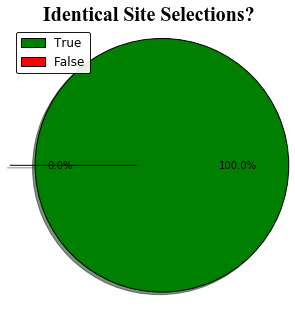

In [15]:
mpl.rcParams['figure.figsize']=5,5
true_site = 0
false_site = 0
for i in solvetime_df['Identical Site Selections?']:
    if i == True:
        true_site += 1
    elif i == False:
        false_site += 1
labels = 'True', 'False'
sizes = [true_site, false_site]
colors = ['green', 'red']
explode = (0.1, 0.1)

plt.pie(sizes, explode=explode, colors=colors,
        autopct='%1.1f%%', 
        shadow=True, startangle=180)

# Title
plt.title('Identical Site Selections?', family='Times New Roman', 
      size=20, color='k', backgroundcolor='w', weight='bold')
plt.legend(labels, loc='upper left', fancybox=True, framealpha=0.9)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

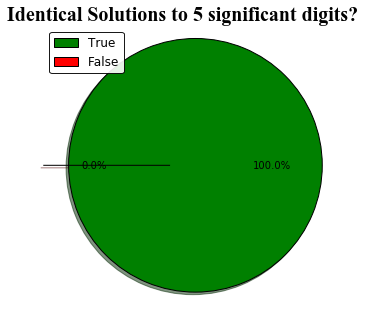

In [16]:
mpl.rcParams['figure.figsize']=5,5
true_obj = 0
false_obj = 0
for i in solvetime_df['Identical Solutions to 5 sig?']:
    if i == True:
        true_obj += 1
    elif i == False:
        false_obj += 1
labels = 'True', 'False'
sizes = [true_obj, false_obj]
colors = ['green', 'red']
explode = (0.1, 0.1)

plt.pie(sizes, explode=explode, colors=colors,
        autopct='%1.1f%%', 
        shadow=True, startangle=180)

# Title
plt.title('Identical Solutions to 5 significant digits?', family='Times New Roman', 
      size=20, color='k', backgroundcolor='w', weight='bold')
plt.legend(labels, loc='upper left', fancybox=True, framealpha=0.9)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()     

## Take Aways:

- ## The CPLEX Python API is incredibly more efficient at building and solving the *p*-Dispersion Problem than the Gurobi Python API.
- ## This is, however, not universal for all optimization problems.
- ## The key factor affecting the real-time solution outcome appears to be the type of constraints being implemented.
- ## The opening contraints found in most facility location problems (i.e. the *p*-Median Problem) are a huge drain on the efficiency of the CPLEX Python API, which the Gurobi API can handle significantly more quickly.

In [17]:
# James Gaboardi, 2016

------------